# OPTIMIZATION FOR DATA SCIENCE - HOMEWORK 1

Graziana Capurso - 2097099 - graziana.capurso@studenti.unipd.it \\
Daniela Di Labbio - 2091677 - daniela.dilabbio@studenti.unipd.it \\
Agata Garbin - 2072693 - agata.garbin@studenti.unipd.it \\
Leonardo Schiavo - 2055519 - leonardo.schiavo.1@studenti.unipd.it 


# Libraries and settings

In [67]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import time 
import scipy.linalg
from scipy.stats import bernoulli    
from scipy.stats import norm    
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import OneHotEncoder   
from scipy.spatial.distance import hamming # used to calculate the accuracy at every iteration
from scipy.optimize import line_search
from sklearn.metrics.pairwise import rbf_kernel # similarity measure 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive

np.random.seed(42)

# Functions

## Loss and weights

In [69]:
# Loss function as written in the notes
def loss_function(w_lab, w_unlab, lab, unk):
  return np.sum(w_lab * (lab - unk.T)**2) + 0.5 * np.sum(w_unlab * (unk - unk.T)**2)

In [70]:
def weight_function(lab_points, unlab_points):
  #rbf kernel is the similarity measure exp(-gamma*norm(x-y)) which is everywhere bounded and has nice properties 
  #arbitrary decision of 1 and 1.25 as gamma between unlab - unlab and lab - unlab
  w_lab =  rbf_kernel(X = lab_points, Y = unlab_points, gamma = 1.25)
  w_unlab = rbf_kernel(X = unlab_points, gamma = 1)  
  return w_lab, w_unlab

In [71]:
# defining a function to calculate loss and accuracy, we are going to do it many times 
def loss_accuracy(w, w_bar, labels, y,true_values, losses =[], accuracies = []):
  value = loss_function(w, w_bar, labels, y)       
  clusters = [-1 if c < 0 else 1 for c in y] #from here on we fix the number of clusters as 2
  accuracy = 1 - hamming(clusters, true_values) 
  losses.append(value) 
  accuracies.append(accuracy)
  return value, accuracy

##Step size rules 

In [72]:
def armijo(w_lab, w_unlab, size, lab, unk, gamma= 1e-4 , delta = 0.1, alpha = 3):
    j = 1
    f0_x = loss_function(w_lab, w_unlab, lab, unk) # loss_function
    f1_x = 2 * np.sum(w_lab* ((-lab) + unk.T), axis = 0) + 2 * np.sum(w_unlab * ((-unk) + unk.T), axis = 0) # gradient
    d = -f1_x
    while (j>0):
        x_new = unk.T+alpha*d
        f0_x_new = loss_function(w_lab, w_unlab, lab, x_new.T) # loss for the new point
        if (f0_x_new<=f0_x+gamma*alpha*np.dot(f1_x,d.T)):
            j = 0
            alpha_armijo = alpha
        else:
            alpha = alpha*delta
    f1_x = f1_x.reshape((size, 1))
    return alpha_armijo*f1_x, f0_x

## Optimization methods 

### Single iteration methods

In [73]:
def random_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001):
  # modifies the global list times by appending the time taken by the iteration
  # returns the value of the new point y
  index = np.random.randint(size_unk) # choice of a random index
  grad = 2 * np.dot(w.T[index].T,(y[index] - labels) ) + 2 * np.dot(w_bar.T[index].T, y[index] - y) # gradient only for the random index
  y[index] = y[index] - rate * grad  # update only the random index of y
  y = y.reshape((size_unk, 1))
  return y

In [74]:
def cyclic_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001):
  # modifies the global list times by appending the time taken by the iteration
  # returns the value of the new point y
  for index in range(size_unk):       # cyclic update of the gradient
    grad = 2 * np.dot(w.T[index].T,(-labels) + y[index]) + 2 * np.dot(w_bar.T[index].T, (-y) + y[index])
    y[index] = y[index] - rate * grad
    y = y.reshape((size_unk, 1))                
  return y

In [75]:
def gd_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001, lnsrc = "fixed"):
  grad = 2 * np.sum(w * ((-labels) + y.T), axis = 0) + 2 * np.sum(w_bar * ((-y) + y.T), axis = 0)
  grad = grad.reshape((size_unk, 1))
  if lnsrc == "fixed":
    y -= rate * grad
  if lnsrc == "exact":
    rate = line_search(fun_min_ls, grad_ls, y, -grad)[0]
    y -= rate * grad
  if lnsrc == "armijo":
    rate, value =  armijo(w, w_bar, size_unk,labels,y)  
    y -= rate 
  y = y.reshape((size_unk, 1))
  return y

In [76]:
def hessian_matrix(w_unlab, w_lab):
    mat = np.copy(-2 * w_unlab)
    for i in range(len(w_unlab)):
          mat[i][i] = 2 * (np.sum(w_lab[:,i]) + np.sum(w_unlab[:,i])) - 2*w_unlab[i][i]
    return mat

In [77]:
def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

In [78]:
def gs_method_oneit(y, w, w_bar, L, size_unk,labels,rate = 0.0001): 
  for index in range(size_unk):       
      grad = 2 * np.dot(w.T[index].T,(-labels) + y[index]) + 2 * np.dot(w_bar.T[index].T, (-y) + y[index])# cyclic update of the gradient
      i_k = np.argmax(abs(grad))
      y[index] = y[index] - (1/L) * grad[i_k]
      y = y.reshape((size_unk, 1))
  return y

### Optimization function

In [79]:
def optimization(w, w_bar, size_unk, labels, true_values, method, lnsrc, rate = 0.0001, epochs = 5000, tol = 1e-3, start = "random", verbose = True): 

    # initialize variables and lists to store data
    losses = []
    times = [0]
    epoch = 0
    diff = 1
    accuracies = []
    root = int(np.floor(np.sqrt(epochs)))

    # initialize the starting point random or all 0 
    if start == "random":
      y = (0.1 * np.random.randn(size_unk)).reshape((-1,1)) # create a random starting point
    if start == "zero": 
      y = (np.zeros(size_unk)).reshape((-1,1)) #initialize to the 0 vector
    if start == "randomsearch":
      y = (0.1 * np.random.randn(size_unk)).reshape((-1,1))
      similar_vectors = [y + (0.1 * np.random.randn(size_unk)).reshape((-1,1)) for i in range(1000)]
      values = [loss_function(w_lab, w_unlab, labels, v) for v in similar_vectors]
      min_value_index = np.argmin(values)
      min_similar_vector = similar_vectors[min_value_index]
      min_value = values[min_value_index]
      y = min_similar_vector
      print("Loss function value of the best y is: {}".format(min_value))

    if method == 'GS':
      H = hessian_matrix(w_bar,w)
      L = estimate_lipschitz_constant(H)

    # optimizing the loss function by the chosen method   
    while diff > tol and epoch < epochs: 
      condition = epochs <= 100 or epoch in range(0, epochs, root)  
      if condition:
        trn1 = time.time()
      if method == "gd":
        y = gd_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001, lnsrc = lnsrc)
      if method == "random":
        y = random_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001)
      if method == "cyclic":
        y = cyclic_method_oneit(y, w, w_bar, size_unk, labels, rate = 0.0001)
      if method == "GS":
        y = gs_method_oneit(y, w, w_bar, L, size_unk, labels, rate = 0.0001)
      if condition:
        trn2 = time.time()
        times.append(trn2 - trn1 + times[-1])
        
      #print the results every some epochs 
      if condition:
          value, accuracy = loss_accuracy(w, w_bar, labels, y, true_values, losses=losses, accuracies=accuracies)
          if verbose:
            print('Epoch: ' + str(epoch) + ', loss: ' + str(round(value, 4)) + ', accuracy: ' + str(round(accuracy, 6)))
          diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1

      epoch += 1

    value, accuracy = loss_accuracy(w, w_bar, labels, y,true_values, losses = losses, accuracies = accuracies) 
    print('Epoch: ' + str(epoch) + ', loss: ' + str(round(value,6)) + ', accuracy: ' + str(round(accuracy,6)))
    return y, losses, times, accuracies

In [80]:
[i for i in range(0,500+1,100)]

[0, 100, 200, 300, 400, 500]

## Dataset management 

In [81]:
def minmax(df):
    result = df.copy()
    for feature_name in df.columns:
      if type(np.array(df[feature_name])[0])!=str : # check on the type of data
          max_value = df[feature_name].max()
          min_value = df[feature_name].min()
          result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [82]:
def hot_encoding(n,labels): 
  # n is the number of clusters
  # labels is a list of clusters i.e. [1,2,3,4,0,1,2,3] which means first cluster, second cluster, ...
  total_labels = ([i for i in range(n)])

  ### integer mapping using LabelEncoder
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

  ### One hot encoding
  onehot_encoder = OneHotEncoder(sparse=False)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

  return onehot_encoded

## Plot functions


In [83]:
def plot_err(opt, true_values,points, method, k = 5000, perc = 0.03): #only fot the generated dataset
  m = int(np.floor(k*perc))
  y = opt[0]
  clusters = [-1 if c < 0 else 1 for c in y]
  boolean_v = (true_values == clusters)

  fig, axs = plt.subplots()

  unk_points_1 = pd.DataFrame(points[m:k])
  unk_points_1['match'] = boolean_v[:k-m]
  unk_points_1 = unk_points_1.to_numpy()

  unk_points_2 = pd.DataFrame(points[m+k:])
  unk_points_2['match'] = boolean_v[k-m:]
  unk_points_2 = unk_points_2.to_numpy()

  axs.scatter(unk_points_2[:,0][unk_points_2[:,3]==True], unk_points_2[:,1][unk_points_2[:,3]==True],s= 5, c='g');
  axs.scatter(unk_points_2[:,0][unk_points_2[:,3]==False], unk_points_2[:,1][unk_points_2[:,3]==False],s= 10, c='r');
  axs.scatter(unk_points_1[:,0][unk_points_1[:,3]==True], unk_points_1[:,1][unk_points_1[:,3]==True],s= 5, c='c');
  axs.scatter(unk_points_1[:,0][unk_points_1[:,3]==False], unk_points_1[:,1][unk_points_1[:,3]==False],s= 10, c='r');
  axs.set_title('Mistaken points ('+method+')')
  fig.show()

In [84]:
def plot_graph(points):
    fig, axs = plt.subplots()
    # unknow points
    axs.scatter(points[:,0][points[:,2]==0], points[:,1][points[:,2]==0],s= 2, c='k')
    # points of first set
    axs.scatter(points[:,0][points[:,2]==-1], points[:,1][points[:,2]==-1],s= 10, c='g')
    # points of second set
    axs.scatter(points[:,0][points[:,2]==1], points[:,1][points[:,2]==1],s= 10, c='c')
    axs.set_title('Toy Dataset')
    return fig

In [85]:
def produce_plot(opt, method,flag = 0, epochs = 10):

  cputime = opt[2][-1]
  losses = opt[1]
  times = opt[2]
  accuracies = opt[3]
  v_x =  np.array(accuracies)
  if flag:
    v_x = v_x > 0.99
    sps = 2
  else:
    v_x = v_x > 0.95
    sps = 0.5
  v_x = np.argmin(v_x)
  fig, axes = plt.subplots(1, 2, figsize = (14,7))
  fig.suptitle('Method = '+ method +'  Ephocs = ' + str(epochs), fontsize=20)
  leg_1 = ['Accuracy = ' + str(round(accuracies[-1], 4)), 'CPU time = ' + str(round(times[-1],4))]
  leg_2 = ['Loss = ' + str(round(losses[-1], 4)), 'CPU time = ' + str(round(times[-1],4))]  
  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
  axes[0].legend(handles,leg_2, loc = 'best', fontsize = 14)
  axes[1].legend(handles,leg_1, loc = 'best', fontsize = 14)
  axes[0].set_xlabel('Time', fontsize = 15)
  axes[1].set_xlabel('Time', fontsize = 15)
  axes[0].set_ylabel('Loss', fontsize = 15)
  axes[1].set_ylabel('Accuracy', fontsize = 15)
  axes[0].plot(times,losses)
  axes[1].plot(times,accuracies)
  axes[1].text(times[v_x]+sps, 0.9, 'Epochs = ' + str(v_x), bbox=dict(fill=False, edgecolor='black', linewidth=1))
  axes[1].text(times[v_x]+sps, 0.885, 'CPU time = ' + str(round(times[v_x],3)), bbox=dict(fill=False, edgecolor='black', linewidth=1))
  axes[1].vlines(times[v_x],0,1,colors='red', linestyles=':')
  plt.ylim(0.8,1)
  plt.rc('xtick',labelsize=12)
  plt.rc('ytick',labelsize=12)

In [86]:
def produce_all_plot_loss(opt_gd, opt_cy, opt_rnd):
  plt.figure()
  plt.plot(opt_gd[2], opt_gd[1])
  plt.plot(opt_cy[2], opt_cy[1])
  plt.plot(opt_rnd[2], opt_rnd[1])
  plt.legend(['GD','Cyclic','Random'])
  plt.xlabel('Time')
  plt.ylabel('Loss')
  plt.title('Time-Loss comparison between different methods')
  plt.show()

In [87]:
def produce_all_plot_acc(opt_gd, opt_cy, opt_rnd, flag):
  plt.figure()

  plt.figure()
  plt.plot(opt_gd[2], opt_gd[3], label = 'GD')
  plt.plot(opt_cy[2], opt_cy[3], label = 'Cyclic')
  plt.plot(opt_rnd[2], opt_rnd[3], label = 'Random')
  
  plt.legend()
  axes = plt.gca()
  if flag:
    axes.set_xlim([0,100])

  plt.xlabel('Time')
  plt.ylabel('Accuracy')
  plt.title('Time-Accuracy comparison between different methods')
  plt.show()

# Generated Dataset

## Creation of the dataset

In [88]:
def clouds_generator(n,k,cov = [[0.1, 0], [0, 0.1]],plot = "omniscient", extract = False, perc = 0.15):
  # n>0, k>1, cov!= null matrix
  # it generates n different clouds each with k points in the plane, the centers of the clouds are the roots of unity. 
  # cov in the  covariance matrix of the normal distribution 
  # plot is if you wanna see the data plotted: "omniscient" if you want to see all, "fog" if you want to see only the labelled, "nope" if you do not want to plot at all
  # extract is if you want to divide (True) the dataset into labelled and unlabelled data of if you dont want to divide and just create the data (False)
  # perc is the percentange of labels you have, usually 15% of the total data lab+unlab
  x, y, labels = [],[],[] #initialize list for data 
  for j in range(n): 
    mean = [np.cos(2*np.pi*j/n), np.sin(2*np.pi*j/n)] #i decided to center the clouds at the roots of unity
    new_data = np.random.multivariate_normal(mean, cov, k).T #generating the clouds with 2D normal distirbution 
    if plot == "omniscient":
      col = "C" + str(j)
      plt.plot(new_data[0], new_data[1], "x", color=col) 
    x.extend(new_data[0].tolist()) #stacking the data 
    y.extend(new_data[1].tolist())
    labels.extend([j for i in range(k)]) #each point (x,y) has the label j 
    #points = list(zip(x, y, labels)) 

  if extract == False:
    #return points #Returning the points in the form (x coord, y coord, label). We can modify and return x,y,label the three list of stacked data
    return x, y, labels

  if extract == True:
    x_lab = list(itertools.chain(*[x[i:i+int(np.floor(k*perc))] for i in range(0, len(x), k)][::1]))
    y_lab = list(itertools.chain(*[y[i:i+int(np.floor(k*perc))] for i in range(0, len(y), k)][::1]))
    labels_lab = list(itertools.chain(*[labels[i:i+int(np.floor(k*perc))] for i in range(0, len(labels), k)][::1]))
    x_unlab = list(itertools.chain(*[x[i+int(np.floor(k*perc)):i+k] for i in range(0, len(x), k)][::1]))
    y_unlab = list(itertools.chain(*[y[i+int(np.floor(k*perc)):i+k] for i in range(0, len(y), k)][::1]))
    labels_unlab = list(itertools.chain(*[labels[i+int(np.floor(k*perc)):i+k] for i in range(0, len(labels), k)][::1]))
    points_lab = list(zip(x_lab,y_lab,labels_lab))
    points_unlab = list(zip(x_unlab, y_unlab, labels_unlab))
    if plot == "fog":
      for point in points_unlab: 
        plt.plot(point[0],point[1],"x",color = '0.8')
      for point in points_lab: 
        col = "C" + str(point[2])
        plt.plot(point[0],point[1],"x",color = col)
    if plot != "nope": 
      plt.axis('equal')
      plt.show()
  
    #return points_lab, points_unlab #as before i return the data (x coord, y coord, label) 
    return x_lab, y_lab, labels_lab, x_unlab, y_unlab, labels_unlab

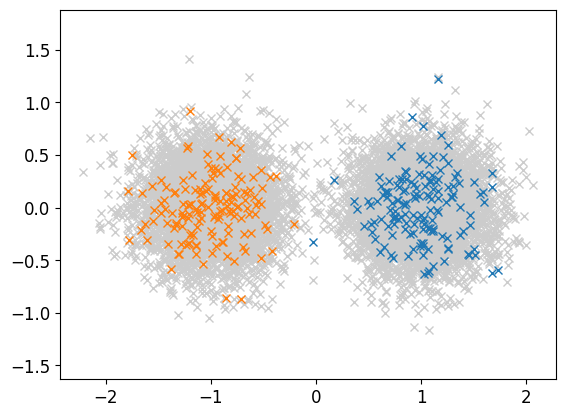

Size of labeled points: (300, 2)
Size of unlabeled points: (9700, 2)


In [89]:
x_lab, y_lab, labels_lab, x_unlab, y_unlab, labels_unlab = clouds_generator(2,5000,extract = True, plot = "fog",perc = 0.03)
lab_points = np.array(list(zip(x_lab, y_lab))) #all 0-cluster's then all 1-cluster's
unlab_points = np.array(list(zip(x_unlab, y_unlab)))

a = [[x_lab[i],y_lab[i],labels_lab[i]] for i in range(len(x_lab)) if labels_lab[i] == 0] 
b = [[x_unlab[i],y_unlab[i],labels_unlab[i]] for i in range(len(x_unlab)) if labels_unlab[i] == 0]
c = [[x_lab[i],y_lab[i],labels_lab[i]] for i in range(len(x_lab)) if labels_lab[i] == 1] 
d = [[x_unlab[i],y_unlab[i],labels_unlab[i]] for i in range(len(x_unlab)) if labels_unlab[i] == 1]
set_ = np.array(a+b+c+d)

print(f'Size of labeled points: {lab_points.shape}')
print(f'Size of unlabeled points: {unlab_points.shape}')

## Weights and accuracy

In [90]:
#weight of our points
[w_lab, w_unlab] = weight_function(lab_points, unlab_points)

#labels
np.shape(lab_points)
labels = np.array([1 if x == 0 else -1 for x in labels_lab]).reshape(len(labels_lab),1)

#target values (in order to calculate the accuracy)
true_values = np.array([1 if x == 0 else -1 for x in labels_unlab])

In [91]:
#weights for line_search
w_lab_ls, w_unlab_ls = w_lab, w_unlab 
n_lab_p = lab_points.shape[0]
labels_ls = np.ones((n_lab_p,1))
labels_ls[int(n_lab_p/2):] = -1
labels_ls = labels

#specific functions for line_search (used in gd_method_oneit with lnsrc = exact)
def fun_min_ls(unk, w_lab = w_lab_ls, w_unlab= w_unlab_ls, lab=labels_ls):
    return np.sum(w_lab * (lab - unk.T)**2 )+ 0.5 * np.sum(w_unlab * (unk - unk.T)**2 ) # loss_value 
 
def grad_ls(y, labels= labels_ls,w= w_lab_ls, w_bar=w_unlab_ls):
    g = (2 * np.sum(w * ((-labels) + y.T), axis = 0) + 2 * np.sum(w_bar * ((-y) + y.T), axis = 0))
    return g

## Optimization

### Fixed - Gradien Descent

In [92]:
#FIXED
print("Optimization Fixed and Gradient Decent")
opt_fix_gd = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = "gd", epochs = 10, verbose =True)
print("*************************************************")
#print(opt_fix_gd[0]) #y
#print(len(opt_fix_gd[1])) #losses
#print(len(opt_fix_gd[2])) #time
#print(len(opt_fix_gd[3])) #accuracies 

Optimization Fixed and Gradient Decent
Epoch: 0, loss: 1001218.9424, accuracy: 0.804227
Epoch: 1, loss: 952012.5564, accuracy: 0.985361
Epoch: 2, loss: 925816.7673, accuracy: 0.997113
Epoch: 3, loss: 905509.6035, accuracy: 0.99866
Epoch: 4, loss: 888910.633, accuracy: 0.998969
Epoch: 5, loss: 875215.1589, accuracy: 0.998969
Epoch: 6, loss: 863889.7047, accuracy: 0.998969
Epoch: 7, loss: 854517.6692, accuracy: 0.999072
Epoch: 8, loss: 846760.1926, accuracy: 0.999072
Epoch: 9, loss: 840338.4682, accuracy: 0.999072
Epoch: 10, loss: 840338.468211, accuracy: 0.999072
*************************************************


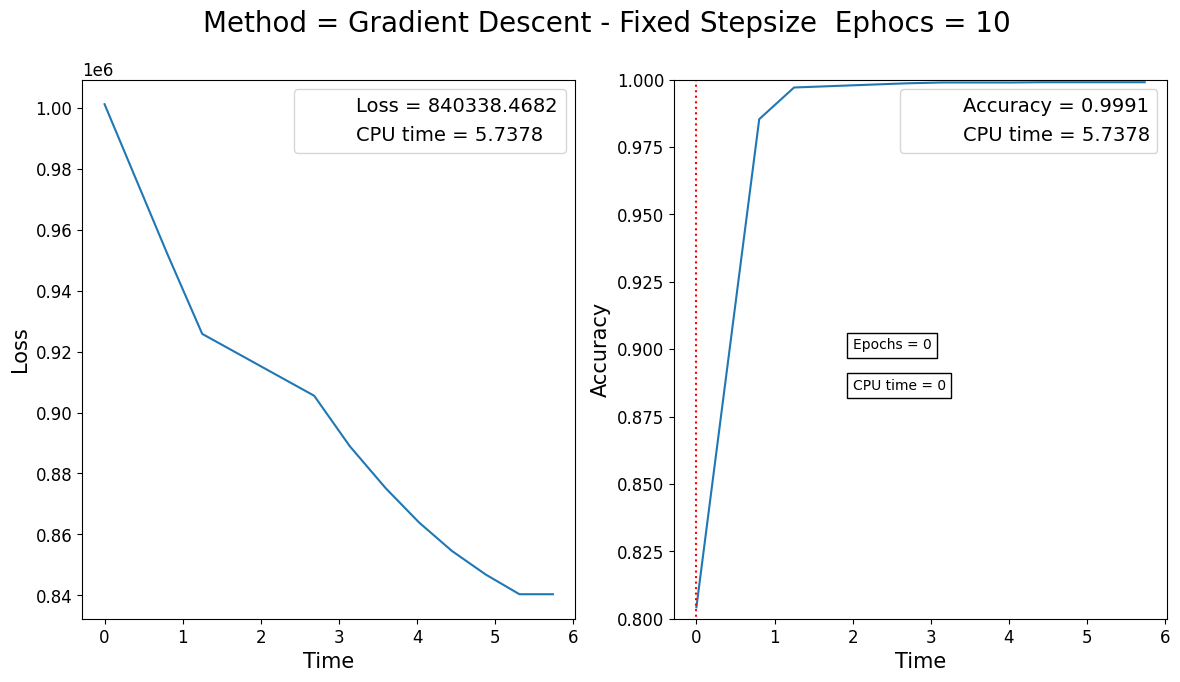

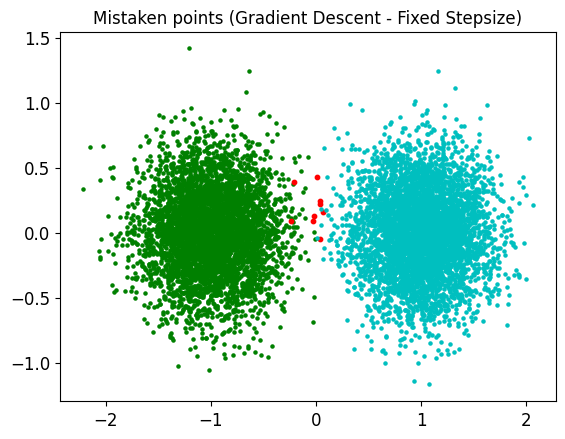

In [93]:
produce_plot(opt_fix_gd, 'Gradient Descent - Fixed Stepsize',flag = 1,epochs = 10)
plot_err(opt_fix_gd, true_values, set_, 'Gradient Descent - Fixed Stepsize')

### Fixed - Random

In [94]:
print("Optimization Fixed and Random")
opt_fix_ran = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = "random", epochs = 50000, verbose = True)
print("*************************************************")
#print(len(opt_fix_ran[1])) #losses
#print(len(opt_fix_ran[2])) #time
#print(len(opt_fix_ran[3])) #accuracies 

Optimization Fixed and Random
Epoch: 0, loss: 1382603.92, accuracy: 0.497732
Epoch: 223, loss: 1374665.0949, accuracy: 0.505258
Epoch: 446, loss: 1366856.8384, accuracy: 0.512474
Epoch: 669, loss: 1359235.4687, accuracy: 0.520103
Epoch: 892, loss: 1351000.6178, accuracy: 0.527216
Epoch: 1115, loss: 1343449.551, accuracy: 0.534021
Epoch: 1338, loss: 1335552.0376, accuracy: 0.541443
Epoch: 1561, loss: 1328338.1906, accuracy: 0.548969
Epoch: 1784, loss: 1321196.4135, accuracy: 0.556804
Epoch: 2007, loss: 1315126.037, accuracy: 0.564227
Epoch: 2230, loss: 1307377.0084, accuracy: 0.570722
Epoch: 2453, loss: 1301287.8418, accuracy: 0.578041
Epoch: 2676, loss: 1294932.6301, accuracy: 0.584021
Epoch: 2899, loss: 1288711.8219, accuracy: 0.590103
Epoch: 3122, loss: 1279162.171, accuracy: 0.596598
Epoch: 3345, loss: 1272165.6129, accuracy: 0.60299
Epoch: 3568, loss: 1265567.7473, accuracy: 0.60866
Epoch: 3791, loss: 1257849.6034, accuracy: 0.614227
Epoch: 4014, loss: 1251948.1888, accuracy: 0.621

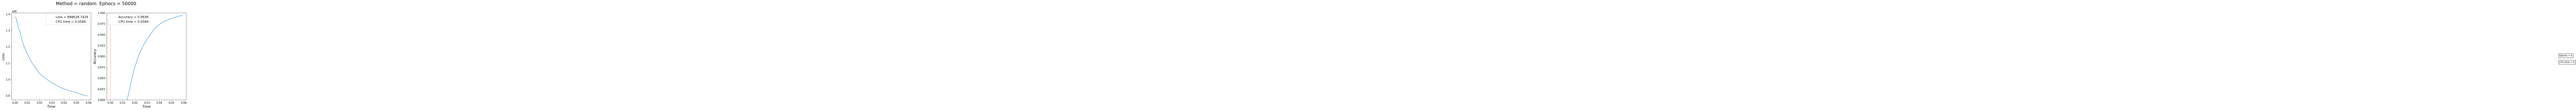

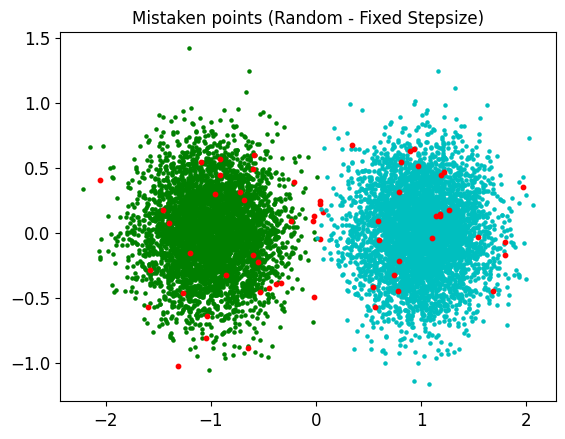

In [95]:
produce_plot(opt_fix_ran, 'random',flag = 1, epochs = 50000)
plot_err(opt_fix_ran, true_values, set_, 'Random - Fixed Stepsize')

### Fixed - Cyclic

In [96]:
print("Optimization Fixed and Cyclic")
opt_fix_cyc = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = 'cyclic', epochs = 10, verbose = True)
print("*************************************************")
#print(len(opt_fix_cyc[1])) #losses
#print(len(opt_fix_cyc[2])) #time
#print(len(opt_fix_cyc[3])) #accuracies 

Optimization Fixed and Cyclic
Epoch: 0, loss: 989603.9373, accuracy: 0.865979
Epoch: 1, loss: 930475.8329, accuracy: 0.991546
Epoch: 2, loss: 898687.8802, accuracy: 0.998351
Epoch: 3, loss: 875964.126, accuracy: 0.998763
Epoch: 4, loss: 859130.9685, accuracy: 0.998866
Epoch: 5, loss: 846583.6571, accuracy: 0.998969
Epoch: 6, loss: 837214.2611, accuracy: 0.999072
Epoch: 7, loss: 830212.6932, accuracy: 0.998969
Epoch: 8, loss: 824978.586, accuracy: 0.999072
Epoch: 9, loss: 821064.9339, accuracy: 0.998969
Epoch: 10, loss: 821064.933911, accuracy: 0.998969
*************************************************


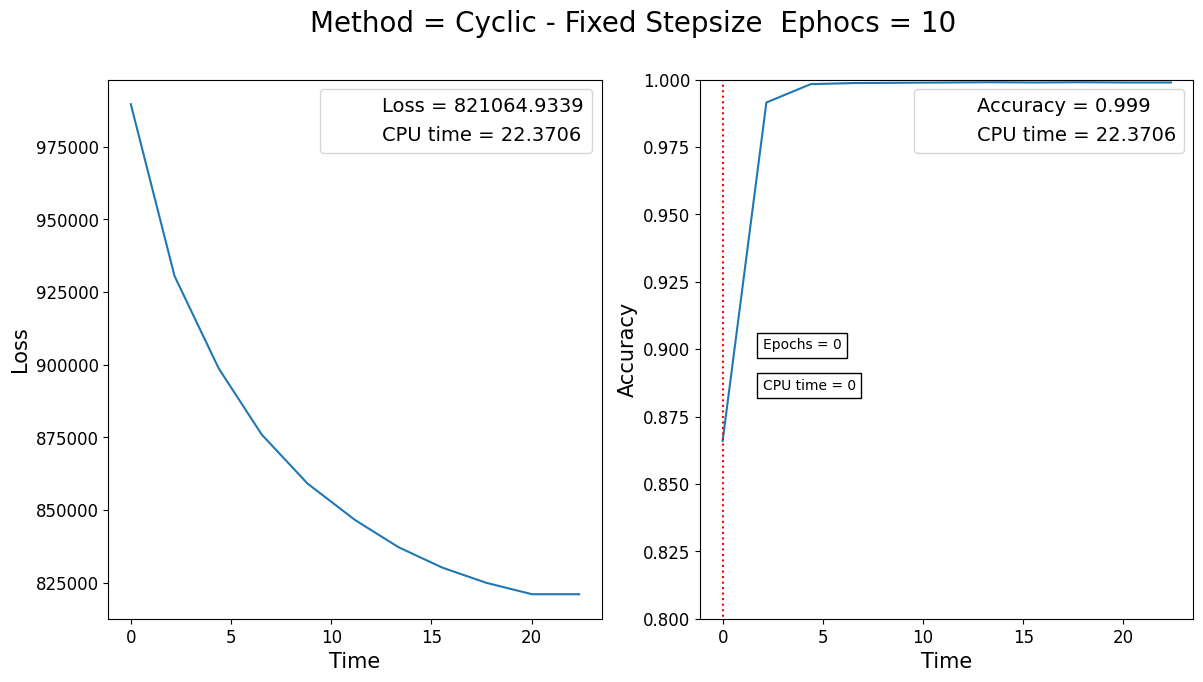

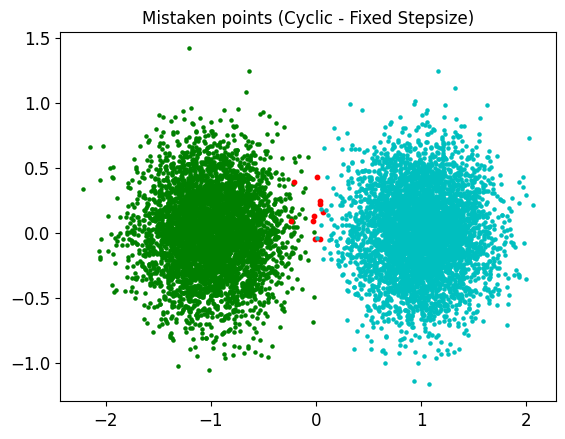

In [97]:
produce_plot(opt_fix_cyc, 'Cyclic - Fixed Stepsize',flag = 1, epochs = 10)
plot_err(opt_fix_cyc, true_values, set_, 'Cyclic - Fixed Stepsize')

### Armijo - Gradient Descent

In [98]:
#ARMIJO
print("Optimization Armijo and Gradient Descent")
opt_arm_gd = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'armijo', method = "gd", epochs = 10, verbose = True)
print("*************************************************")
#print(len(opt_arm_gd[1])) #losses
#print(len(opt_arm_gd[2])) #time
#print(len(opt_arm_gd[3])) #accuracies 

Optimization Armijo and Gradient Descent
Epoch: 0, loss: 1220592.2284, accuracy: 0.531753
Epoch: 1, loss: 1122178.4372, accuracy: 0.582268
Epoch: 2, loss: 1060369.2411, accuracy: 0.649381
Epoch: 3, loss: 1028971.3919, accuracy: 0.890825
Epoch: 4, loss: 970860.3898, accuracy: 0.949485
Epoch: 5, loss: 935342.8146, accuracy: 0.985979
Epoch: 6, loss: 934101.7387, accuracy: 0.985258
Epoch: 7, loss: 897552.6099, accuracy: 0.996701
Epoch: 8, loss: 875674.1382, accuracy: 0.998763
Epoch: 9, loss: 862253.0609, accuracy: 0.998763
Epoch: 10, loss: 862253.06095, accuracy: 0.998763
*************************************************


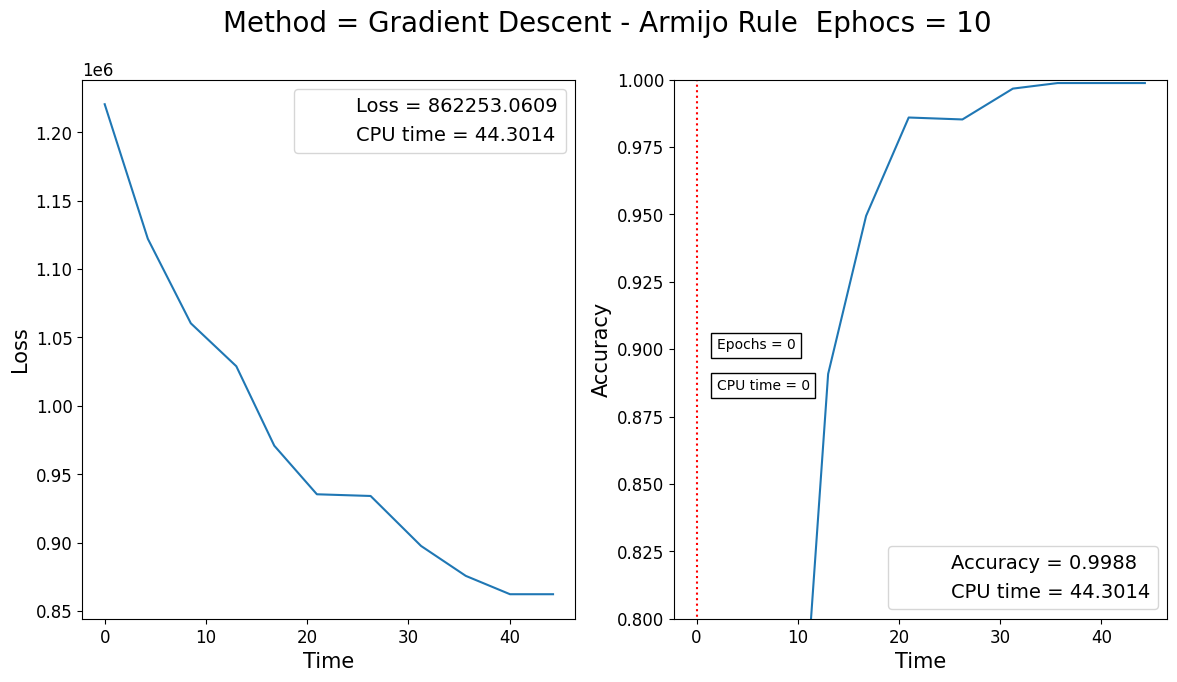

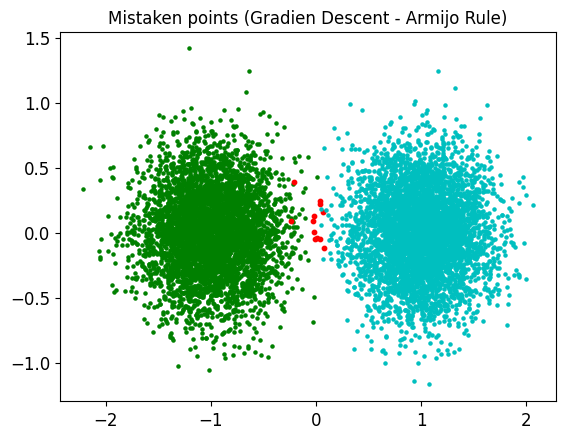

In [99]:
produce_plot(opt_arm_gd, 'Gradient Descent - Armijo Rule',flag = 1, epochs = 10)
plot_err(opt_arm_gd, true_values, set_, 'Gradien Descent - Armijo Rule')

### Exact - Gradient Descent

In [100]:
#EXACT 
print("Optimization Exact and Gradient Descent")
opt_exa_gd = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'exact', method = "gd", epochs = 10, verbose = True) 
print("*************************************************")
#print(len(opt_exa_gd[1])) #losses
#print(len(opt_exa_gd[2])) #time
#print(len(opt_exa_gd[3])) #accuracies 

Optimization Exact and Gradient Descent
Epoch: 0, loss: 969505.1323, accuracy: 0.965876
Epoch: 1, loss: 895356.9144, accuracy: 0.997113
Epoch: 2, loss: 857218.8831, accuracy: 0.998969
Epoch: 3, loss: 837773.3287, accuracy: 0.999072
Epoch: 4, loss: 826312.7043, accuracy: 0.999175
Epoch: 5, loss: 819544.6712, accuracy: 0.999072
Epoch: 6, loss: 815496.9565, accuracy: 0.999072
Epoch: 7, loss: 813080.3316, accuracy: 0.999072
Epoch: 8, loss: 811630.3288, accuracy: 0.999072
Epoch: 9, loss: 810761.5209, accuracy: 0.999072
Epoch: 10, loss: 810761.520856, accuracy: 0.999072
*************************************************


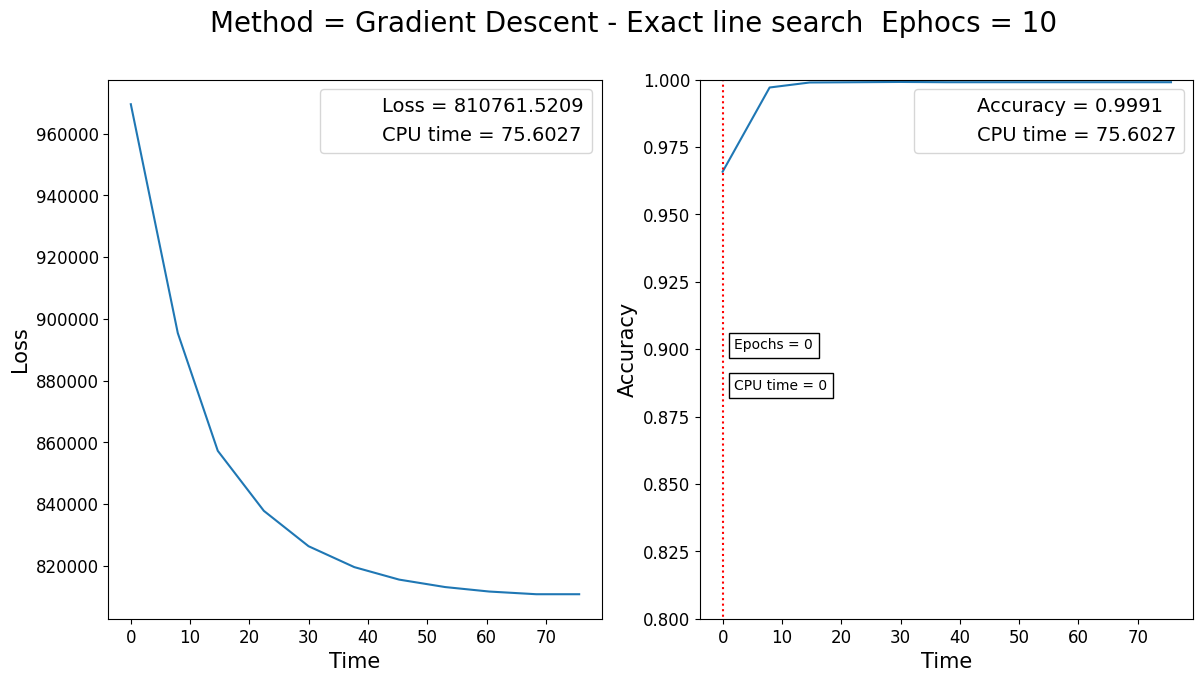

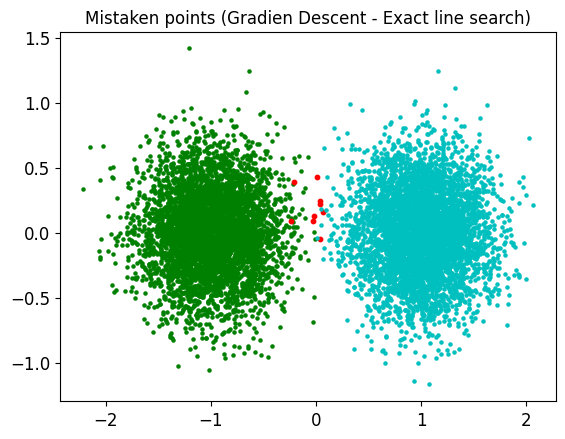

In [101]:
produce_plot(opt_exa_gd, 'Gradient Descent - Exact line search',flag = 1, epochs = 10)
plot_err(opt_exa_gd, true_values, set_, 'Gradien Descent - Exact line search') 

### Gauss Southwell

In [102]:
print("Optimization Gauss Southwell BCGD")
opt_exa_gs = optimization(w_lab, w_unlab,unlab_points.shape[0], labels,true_values,lnsrc='exact', method = "GS", epochs = 10, verbose = True )
print("*************************************************")
#print(len(opt_exa_gs[1])) #losses
#print(len(opt_exa_gs[2])) #time
#print(len(opt_exa_gs[3])) #accuracies 

Optimization Gauss Southwell BCGD
Epoch: 0, loss: 965293.7546, accuracy: 0.942371
Epoch: 1, loss: 913077.4989, accuracy: 0.996804
Epoch: 2, loss: 880597.4111, accuracy: 0.998763
Epoch: 3, loss: 858449.0429, accuracy: 0.998969
Epoch: 4, loss: 843229.0202, accuracy: 0.998969
Epoch: 5, loss: 832748.8053, accuracy: 0.998969
Epoch: 6, loss: 825525.7623, accuracy: 0.998969
Epoch: 7, loss: 820545.2692, accuracy: 0.998969
Epoch: 8, loss: 817110.1635, accuracy: 0.998969
Epoch: 9, loss: 814740.5094, accuracy: 0.998969
Epoch: 10, loss: 814740.509408, accuracy: 0.998969
*************************************************


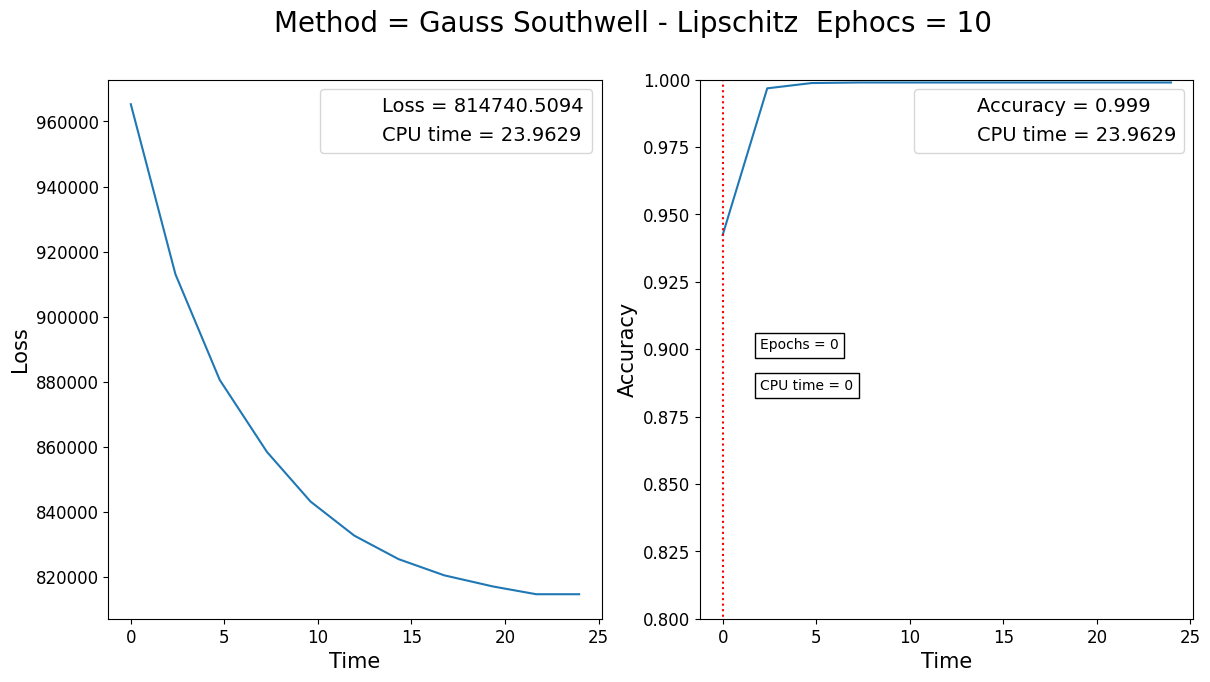

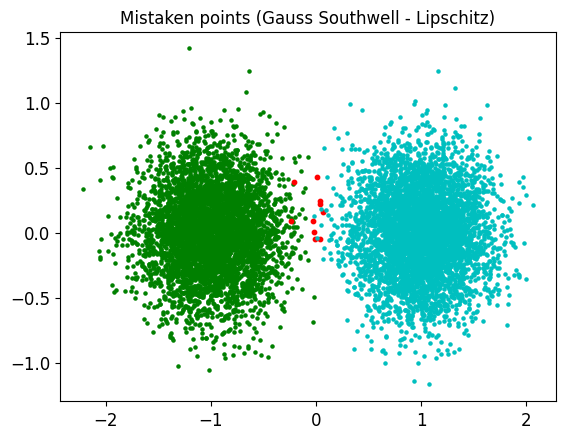

In [103]:
produce_plot(opt_exa_gs, 'Gauss Southwell - Lipschitz',flag = 1, epochs = 10)
plot_err(opt_exa_gs, true_values, set_, 'Gauss Southwell - Lipschitz') 

### Other plots

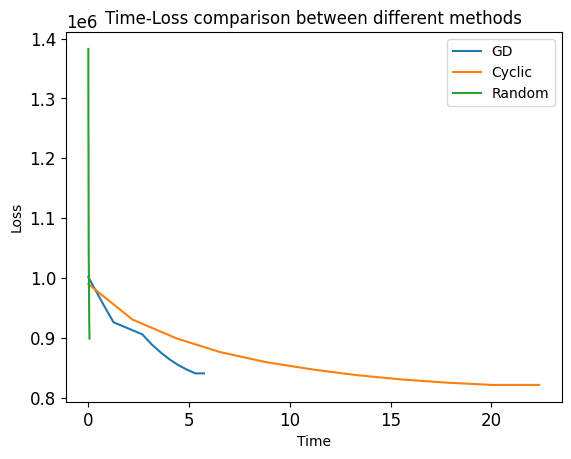

In [104]:
produce_all_plot_loss(opt_fix_gd, opt_fix_cyc, opt_fix_ran)

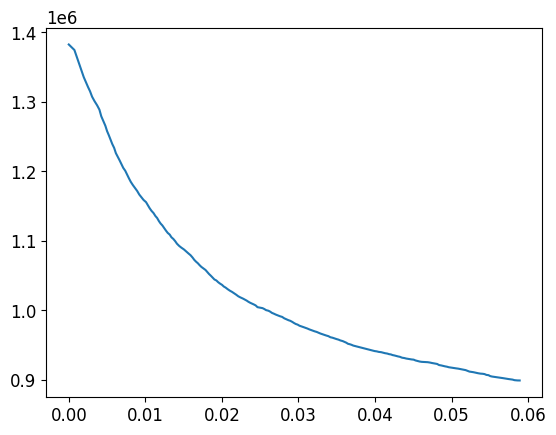

In [105]:
plt.figure()
plt.plot(opt_fix_ran[2], opt_fix_ran[1])
plt.show()

<Figure size 640x480 with 0 Axes>

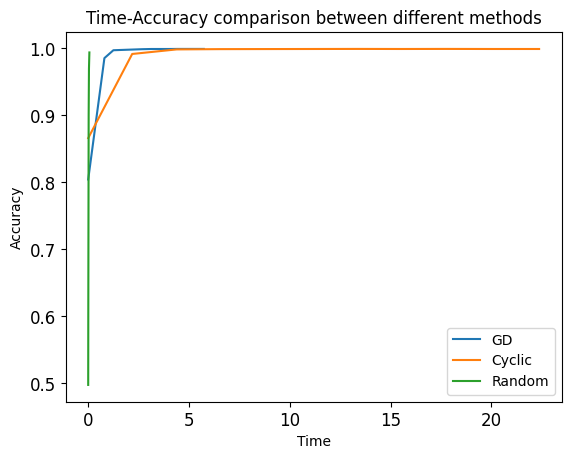

In [106]:
produce_all_plot_acc(opt_fix_gd, opt_fix_cyc, opt_fix_ran, 0)

# Fraud Dataset


In [107]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [108]:
df_cards= pd.read_csv("/content/drive/MyDrive/HW Optimization/Dataset/creditcard.csv")

## Preprocessing

In [109]:
df_cards.dropna
df_cards[:1]
print("unique values in the classification class: {}".format(df_cards["class"].unique()))
num_ones = (df_cards.iloc[:, -1] == 1).sum()
num_zeros = (df_cards.iloc[:, -1] == 0).sum()
print("Original number of 0s:", num_zeros)
print("Original number of 1s:", num_ones)

# calculate the difference between the number of 0s and 1s
diff = num_zeros - num_ones

# randomly select rows with 0s in the last column to remove
remove_indices = np.random.choice(df_cards.index[df_cards.iloc[:, -1] == 0], size=abs(diff), replace=False)

# remove selected rows from DataFrame
df_cards = df_cards.drop(remove_indices)

# check if the number of 0s and 1s are now the same
num_ones = (df_cards.iloc[:, -1] == 1).sum()
num_zeros = (df_cards.iloc[:, -1] == 0).sum()
print("New number of 0s:", num_zeros)
print("New number of 1s:", num_ones)

unique values in the classification class: [0 1]
Original number of 0s: 284315
Original number of 1s: 492
New number of 0s: 492
New number of 1s: 492


## Standard scaler and PCA

In [110]:
X = df_cards.iloc[:, :-1].values
y = df_cards.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components = 0.85) #n_components=0.85
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
number_features = pca.n_components_
explained_variance = pca.explained_variance_ratio_
print("number of features chosen: {}".format(number_features))
print("explained variance: {}".format(sum(explained_variance)))

number of features chosen: 11
explained variance: 0.8564093049551521


## Adaptig the dataframe to the usual notation



In [111]:
data = np.hstack((X_train, y_train.reshape(-1, 1)))
df = pd.DataFrame(data)
df.iloc[:, -1] = df.iloc[:, -1].replace({0: -1, 1: 1})
print("shape of the original df: {}".format(df.shape))
df_with_1 = df[df.iloc[:, -1] == 1]
print("shape of df_with_one {}".format(df_with_1.shape))
df_with_minus_1 = df[df.iloc[:, -1] == -1]
print("shape of df_with_minus_one {}".format(df_with_minus_1.shape))

p=0.15 # percentage of labelled data
num_with_1=df_with_1.shape[0]             # number of male
num_with_minus_1=df_with_minus_1.shape[0]     
p_with_1=math.ceil(p * num_with_1)        # number of labelled with_1
p_with_minus_1=math.ceil(p * num_with_minus_1)    # number of labelled with_minus_1
lab_with_1=df_with_1.iloc[:p_with_1,:]         # dataframe of labelled with_1 with label at the end
lab_with_minus_1=df_with_minus_1.iloc[:p_with_minus_1,:]   # dataframe of labelled with_minus_1 with label at the end 
unlab_with_1=df_with_1.iloc[p_with_1:,:]       # dataframe of labelled with_1 with label at the end
unlab_with_minus_1=df_with_minus_1.iloc[p_with_minus_1:,:] 

print("shape of 1 lab: {}".format(lab_with_1.shape))
print("shape of -1 lab {}".format(lab_with_minus_1.shape))
print("shape of 1 unlab {}".format(unlab_with_1.shape))
print("shape of -1 unlab {}".format(unlab_with_minus_1.shape))

#note: the classes are slightly different due to the tran_test split in the pca

shape of the original df: (885, 12)
shape of df_with_one (438, 12)
shape of df_with_minus_one (447, 12)
shape of 1 lab: (66, 12)
shape of -1 lab (68, 12)
shape of 1 unlab (372, 12)
shape of -1 unlab (379, 12)


In [112]:
# target vectors y_lab e y_unlab, y_unlab required for accuracy 
y_lab_df = pd.concat([lab_with_1.iloc[:, -1], lab_with_minus_1.iloc[:, -1]])
y_unlab_df=pd.concat([unlab_with_1.iloc[:,-1], unlab_with_minus_1.iloc[:,-1]]) 

# transform into numpy array 
y_lab_array=np.array(y_lab_df[:])
y_unlab_array=np.array(y_unlab_df[:])
y_lab_array = np.reshape(y_lab_array,(y_lab_array.shape[0],1)) # transpose
y_unlab_array = np.reshape(y_unlab_array,(y_unlab_array.shape[0],1)) # transpose
y_unlab_array = np.ravel(y_unlab_array)

# assign 0 to unlabelled data
unlab_with_1.iloc[:,-1]=0
unlab_with_minus_1.iloc[:,-1]=0

# creation of the final dataframe containing all the points 
df_final=pd.concat([lab_with_1, lab_with_minus_1, unlab_with_1, unlab_with_minus_1])

# dataframe of labelled and unlabelled data
df_lab=pd.concat([lab_with_1,lab_with_minus_1])
df_unlab=pd.concat([unlab_with_1,unlab_with_minus_1])

# transform into numpy array 
array_final=np.array(df_final)
array_lab=np.array(df_lab)
array_unlab=np.array(df_unlab)

num, last= array_final.shape # number of total points (5001) number of features (7)

# weights for real dataset
w_lab, w_unlab = weight_function(array_lab, array_unlab)

# weights for implement the exact line_search
w_lab, w_unlab = weight_function(array_lab, array_unlab)
w_lab_ls, w_unlab_ls = w_lab, w_unlab 
n_lab_p = array_lab.shape[0]
labels_ls = y_lab_array 

def fun_min_ls(unk, w_lab = w_lab_ls, w_unlab= w_unlab_ls, lab=labels_ls):
    return np.sum(w_lab * (lab - unk.T)**2 )+ 0.5 * np.sum(w_unlab * (unk - unk.T)**2 ) # loss_value 
 
def grad_ls(y, labels= labels_ls,w= w_lab_ls, w_bar=w_unlab_ls):
    g = (2 * np.sum(w * ((-labels) + y.T), axis = 0) + 2 * np.sum(w_bar * ((-y) + y.T), axis = 0))
    return g

<ipython-input-112-f8f1f41fc01e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlab_with_1.iloc[:,-1]=0
<ipython-input-112-f8f1f41fc01e>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  unlab_with_1.iloc[:,-1]=0
<ipython-input-112-f8f1f41fc01e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

## Optimization

### Fixed - Gradien Descent

In [113]:
#FIXED
print("Optimization Fixed and Gradient Decent")
opt_real_fix_gd = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , method= 'gd', rate = 0.0001, epochs = 100,lnsrc="fixed", verbose = True, start = "zero")
print("*************************************************")

Optimization Fixed and Gradient Decent
Epoch: 0, loss: 60.0269, accuracy: 0.888149
Epoch: 1, loss: 60.0205, accuracy: 0.88016
Epoch: 2, loss: 60.0141, accuracy: 0.88016
Epoch: 3, loss: 60.0078, accuracy: 0.88016
Epoch: 4, loss: 60.0014, accuracy: 0.88016
Epoch: 5, loss: 59.995, accuracy: 0.88016
Epoch: 6, loss: 59.9887, accuracy: 0.88016
Epoch: 7, loss: 59.9823, accuracy: 0.88016
Epoch: 8, loss: 59.976, accuracy: 0.88016
Epoch: 9, loss: 59.9697, accuracy: 0.88016
Epoch: 10, loss: 59.9634, accuracy: 0.88016
Epoch: 11, loss: 59.957, accuracy: 0.88016
Epoch: 12, loss: 59.9507, accuracy: 0.881491
Epoch: 13, loss: 59.9444, accuracy: 0.881491
Epoch: 14, loss: 59.9381, accuracy: 0.881491
Epoch: 15, loss: 59.9318, accuracy: 0.881491
Epoch: 16, loss: 59.9256, accuracy: 0.881491
Epoch: 17, loss: 59.9193, accuracy: 0.882823
Epoch: 18, loss: 59.913, accuracy: 0.882823
Epoch: 19, loss: 59.9068, accuracy: 0.882823
Epoch: 20, loss: 59.9005, accuracy: 0.882823
Epoch: 21, loss: 59.8943, accuracy: 0.882

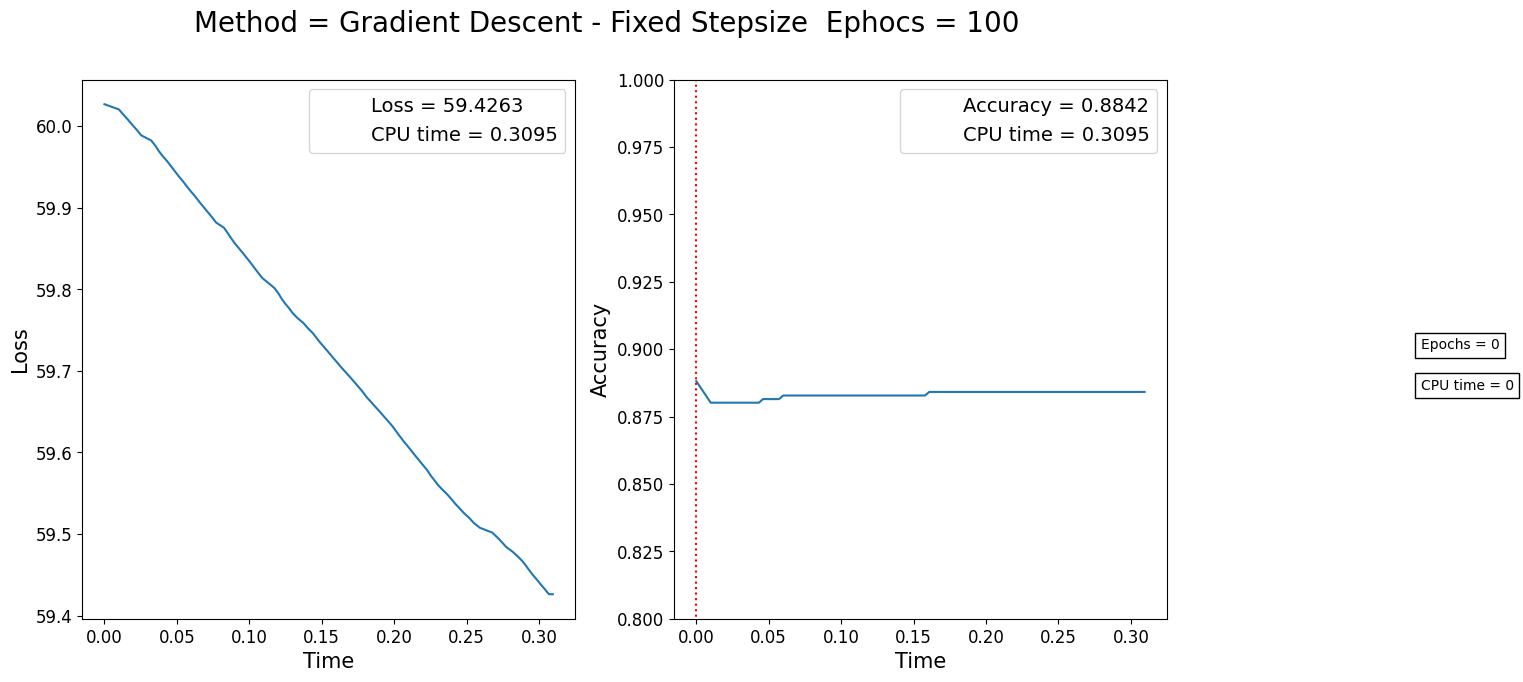

In [114]:
produce_plot(opt_real_fix_gd, 'Gradient Descent - Fixed Stepsize',0, epochs = 100)











### Fixed - Random

In [115]:
print("Optimization Fixed and Random")
opt_real_fix_ran = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', method = "random", epochs = 3*10**5, verbose = True, start = "zero", tol = -1)
print("*************************************************")

Optimization Fixed and Random
Epoch: 0, loss: 60.0333, accuracy: 0.49534
Epoch: 547, loss: 60.0276, accuracy: 0.707057
Epoch: 1094, loss: 60.0228, accuracy: 0.810919
Epoch: 1641, loss: 60.0185, accuracy: 0.849534
Epoch: 2188, loss: 60.014, accuracy: 0.866844
Epoch: 2735, loss: 60.0093, accuracy: 0.869507
Epoch: 3282, loss: 60.0056, accuracy: 0.873502
Epoch: 3829, loss: 60.0006, accuracy: 0.874834
Epoch: 4376, loss: 59.9963, accuracy: 0.878828
Epoch: 4923, loss: 59.9911, accuracy: 0.88016
Epoch: 5470, loss: 59.9867, accuracy: 0.88016
Epoch: 6017, loss: 59.9819, accuracy: 0.88016
Epoch: 6564, loss: 59.9784, accuracy: 0.88016
Epoch: 7111, loss: 59.9739, accuracy: 0.88016
Epoch: 7658, loss: 59.9694, accuracy: 0.88016
Epoch: 8205, loss: 59.9658, accuracy: 0.881491
Epoch: 8752, loss: 59.9616, accuracy: 0.881491
Epoch: 9299, loss: 59.9559, accuracy: 0.881491
Epoch: 9846, loss: 59.9507, accuracy: 0.881491
Epoch: 10393, loss: 59.9464, accuracy: 0.881491
Epoch: 10940, loss: 59.9422, accuracy: 0.

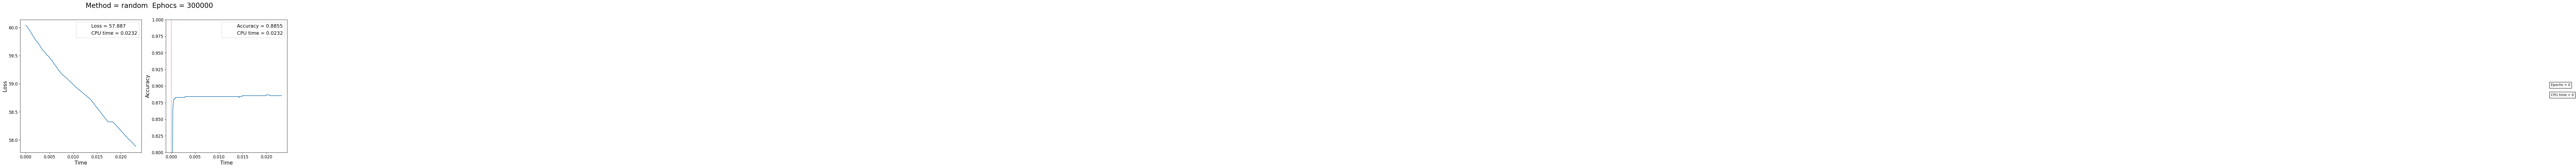

In [116]:
produce_plot(opt_real_fix_ran, 'random',0, epochs = 3*10**5)

### Fixed - Cyclic

In [117]:
print("Optimization Fixed and Cyclic")
opt_real_fix_cyc = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', method = 'cyclic', epochs = 30, verbose = True, start = "zero")
print("*************************************************")

Optimization Fixed and Cyclic
Epoch: 0, loss: 60.0269, accuracy: 0.88016
Epoch: 1, loss: 60.0205, accuracy: 0.88016
Epoch: 2, loss: 60.0141, accuracy: 0.88016
Epoch: 3, loss: 60.0077, accuracy: 0.88016
Epoch: 4, loss: 60.0014, accuracy: 0.88016
Epoch: 5, loss: 59.995, accuracy: 0.88016
Epoch: 6, loss: 59.9886, accuracy: 0.88016
Epoch: 7, loss: 59.9823, accuracy: 0.88016
Epoch: 8, loss: 59.976, accuracy: 0.88016
Epoch: 9, loss: 59.9696, accuracy: 0.88016
Epoch: 10, loss: 59.9633, accuracy: 0.88016
Epoch: 11, loss: 59.957, accuracy: 0.881491
Epoch: 12, loss: 59.9507, accuracy: 0.881491
Epoch: 13, loss: 59.9444, accuracy: 0.881491
Epoch: 14, loss: 59.9381, accuracy: 0.881491
Epoch: 15, loss: 59.9318, accuracy: 0.882823
Epoch: 16, loss: 59.9255, accuracy: 0.882823
Epoch: 17, loss: 59.9192, accuracy: 0.882823
Epoch: 18, loss: 59.9129, accuracy: 0.882823
Epoch: 19, loss: 59.9067, accuracy: 0.882823
Epoch: 20, loss: 59.9004, accuracy: 0.882823
Epoch: 21, loss: 59.8942, accuracy: 0.882823
Epoc

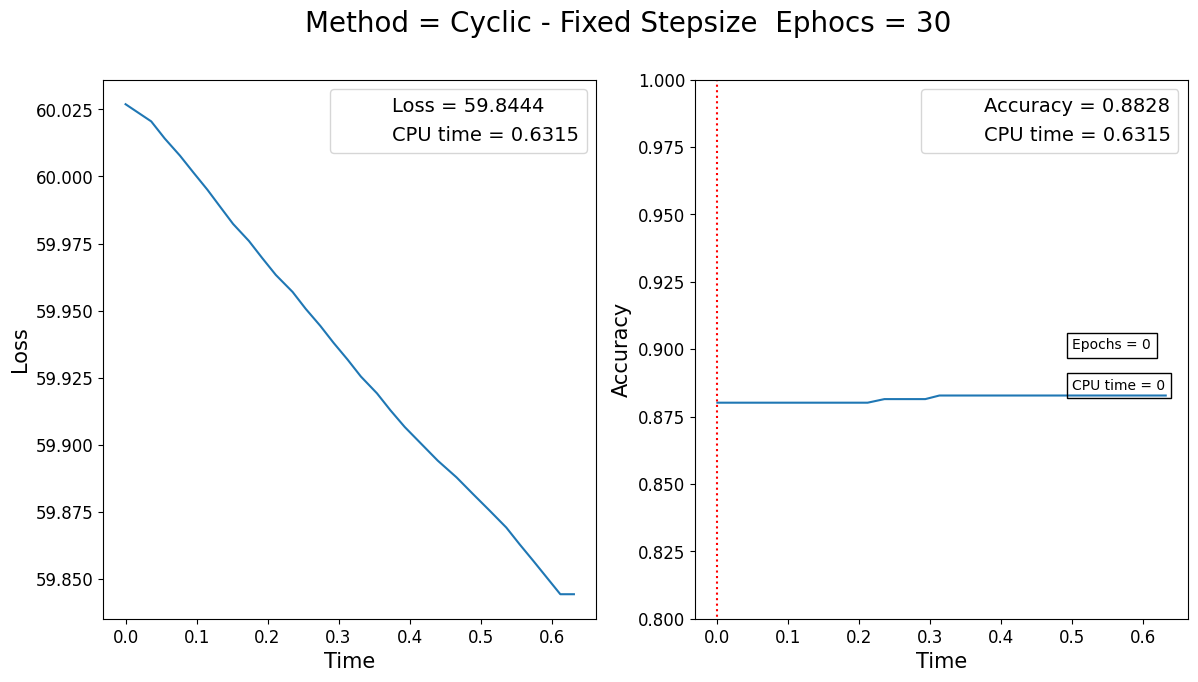

In [118]:
produce_plot(opt_real_fix_cyc, 'Cyclic - Fixed Stepsize',0, epochs = 30)

### Armijo - Gradient Descent

In [119]:
#ARMIJO
print("Optimization Armijo and Gradient Descent")
opt_real_arm_gd = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'armijo', method = "gd", epochs = 1,rate = 0.0001, verbose = True, tol = 1e-10, start = "zero")
print("*************************************************")
# già ad epoch = 2 l'accuracy cala!

Optimization Armijo and Gradient Descent
Epoch: 0, loss: 57.1421, accuracy: 0.888149
Epoch: 1, loss: 57.142068, accuracy: 0.888149
*************************************************


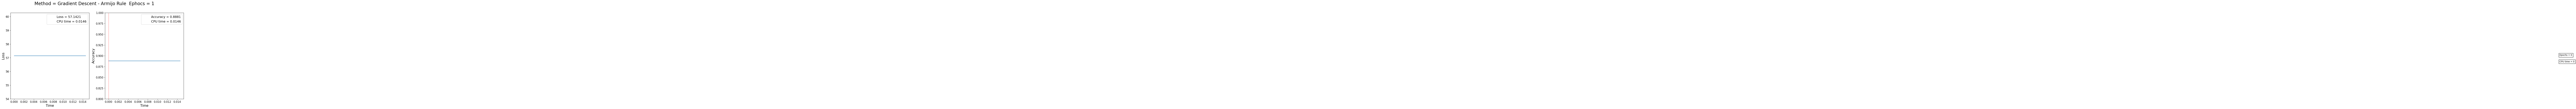

In [120]:
produce_plot(opt_real_arm_gd, 'Gradient Descent - Armijo Rule',0, epochs = 1)

### Exact - Gradient Descent

In [121]:
#EXACT 
print("Optimization Exact and Gradient Descent")
opt_real_exa_gd = optimization(w_lab, w_unlab,array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'exact', method = "gd", epochs = 1, verbose = True, tol = 1e-10, start = "zero")
print("*************************************************")
# già ad epoch = 2 l'accuracy cala!

Optimization Exact and Gradient Descent
Epoch: 0, loss: 54.3858, accuracy: 0.888149
Epoch: 1, loss: 54.385767, accuracy: 0.888149
*************************************************


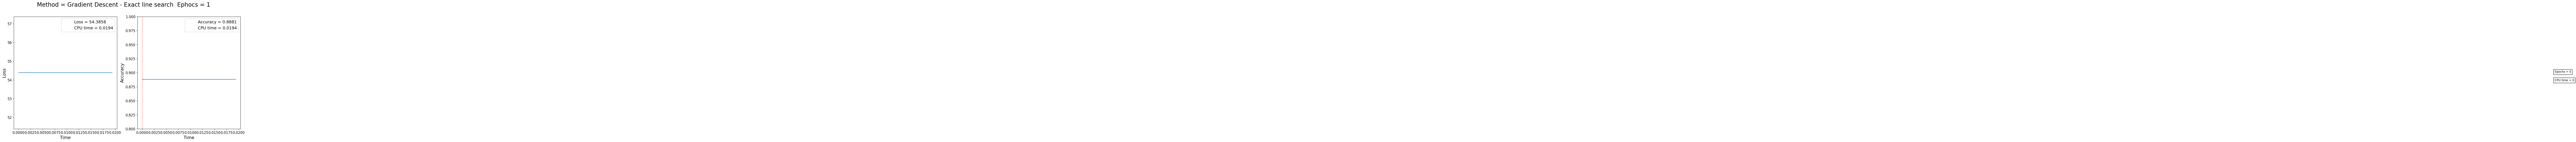

In [122]:
produce_plot(opt_real_exa_gd, 'Gradient Descent - Exact line search',0, epochs = 1)

### Gauss Southwell

In [123]:
print("Optimization Gauss Southwell BCGD")
opt_real_exa_gs = optimization(w_lab, w_unlab,array_unlab.shape[0], y_lab_array,y_unlab_array,lnsrc='exact', method = "GS", epochs = 1, start = "zero")
print("*************************************************")
# già ad epoch = 2 l'accuracy cala!

Optimization Gauss Southwell BCGD
Epoch: 0, loss: 58.1985, accuracy: 0.886818
Epoch: 1, loss: 58.198544, accuracy: 0.886818
*************************************************


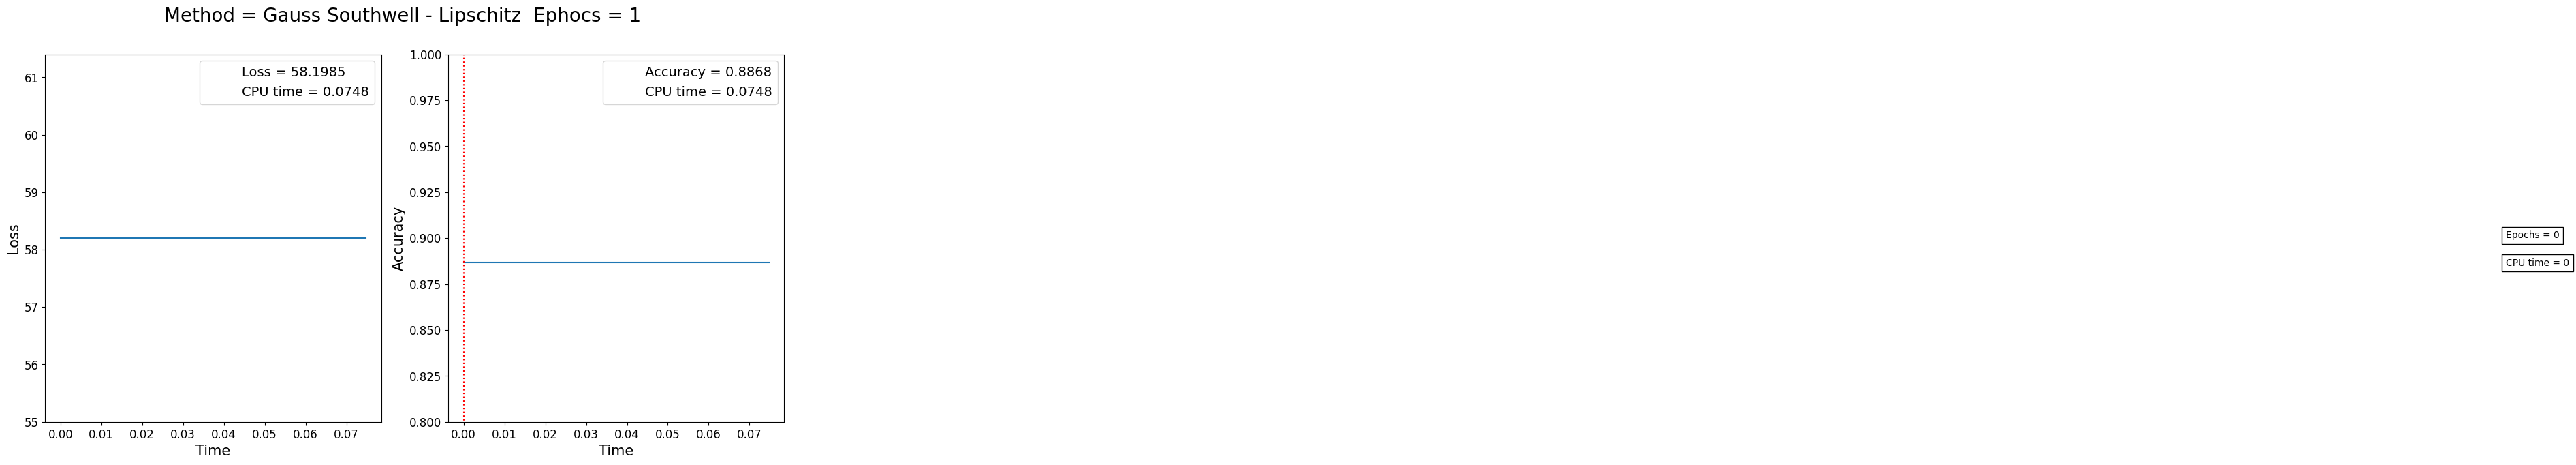

In [124]:
produce_plot(opt_real_exa_gs, 'Gauss Southwell - Lipschitz',0, epochs = 1)

### Other plots

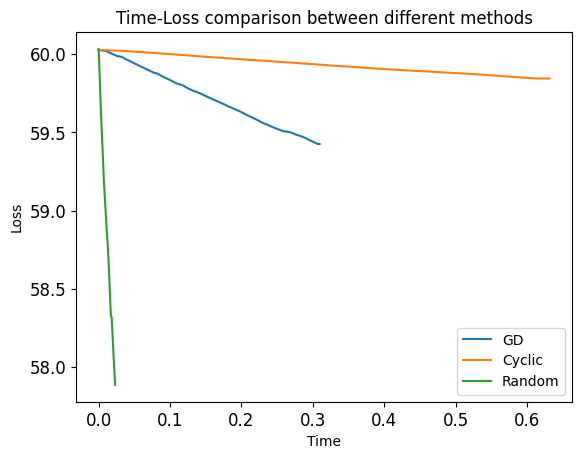

In [125]:
produce_all_plot_loss(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran)

<Figure size 640x480 with 0 Axes>

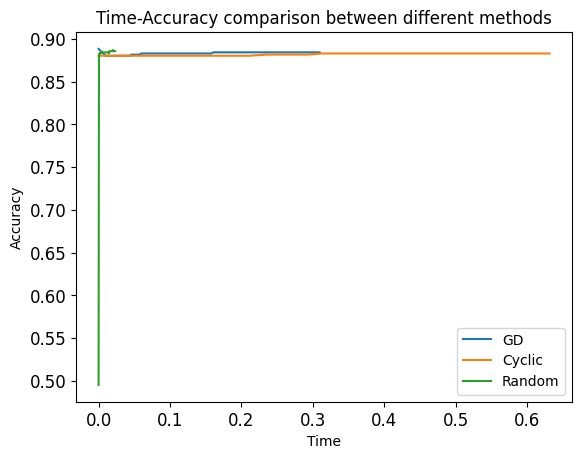

In [126]:
produce_all_plot_acc(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran,0)

# Swarm Dataset


In [127]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [128]:
df_swarm= pd.read_csv("/content/drive/MyDrive/HW Optimization/Dataset/Swarm_Behaviour.csv")

## Preprocessing

In [129]:
df_swarm.dropna
print("unique values in the classification class: {}".format(df_swarm["Swarm_Behaviour"].unique()))
num_ones = (df_swarm.iloc[:, -1] == 1).sum()
num_zeros = (df_swarm.iloc[:, -1] == 0).sum()
print("Original number of 0s:", num_zeros)
print("Original number of 1s:", num_ones)

# calculate the difference between the number of 0s and 1s
diff = num_zeros - num_ones

# randomly select rows with 0s in the last column to remove
remove_indices = np.random.choice(df_swarm.index[df_swarm.iloc[:, -1] == 0], size=abs(diff), replace=False)

# remove selected rows from DataFrame
df_swarm = df_swarm.drop(remove_indices)

# check if the number of 0s and 1s are now the same
num_ones = (df_swarm.iloc[:, -1] == 1).sum()
num_zeros = (df_swarm.iloc[:, -1] == 0).sum()
print("New number of 0s:", num_zeros)
print("New number of 1s:", num_ones)

unique values in the classification class: [0. 1.]
Original number of 0s: 15355
Original number of 1s: 7954
New number of 0s: 7954
New number of 1s: 7954


## Standard scaler and PCA

In [130]:
X = df_swarm.iloc[:, :-1].values
y = df_swarm.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = 8) #n_components=0.5 ottengo 28 variabili ok per tutto ma GS non gira per problemi della ram, provo con 8 componenti 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
number_features = pca.n_components_
explained_variance = pca.explained_variance_ratio_
print(number_features)
print(sum(explained_variance))

8
0.39720301885065656


## Adaptig the dataframe to the usual notation



In [131]:
data = np.hstack((X_train, y_train.reshape(-1, 1)))
df = pd.DataFrame(data)
df.iloc[:, -1] = df.iloc[:, -1].replace({0: -1, 1: 1})
print("shape of the original df: {}".format(df.shape))
df_with_1 = df[df.iloc[:, -1] == 1]
print("shape of df_with_one {}".format(df_with_1.shape))
df_with_minus_1 = df[df.iloc[:, -1] == -1]
print("shape of df_with_minus_one {}".format(df_with_minus_1.shape))

p=0.15 # percentage of labelled data
num_with_1=df_with_1.shape[0]             # number of male
num_with_minus_1=df_with_minus_1.shape[0]     
p_with_1=math.ceil(p * num_with_1)        # number of labelled with_1
p_with_minus_1=math.ceil(p * num_with_minus_1)    # number of labelled with_minus_1
lab_with_1=df_with_1.iloc[:p_with_1,:]         # dataframe of labelled with_1 with label at the end
lab_with_minus_1=df_with_minus_1.iloc[:p_with_minus_1,:]   # dataframe of labelled with_minus_1 with label at the end 
unlab_with_1=df_with_1.iloc[p_with_1:,:]       # dataframe of labelled with_1 with label at the end
unlab_with_minus_1=df_with_minus_1.iloc[p_with_minus_1:,:] 

print("shape of 1 lab: {}".format(lab_with_1.shape))
print("shape of -1 lab {}".format(lab_with_minus_1.shape))
print("shape of 1 unlab {}".format(unlab_with_1.shape))
print("shape of -1 unlab {}".format(unlab_with_minus_1.shape))

#note: the classes are slightly different due to the tran_test split in the pca

shape of the original df: (14317, 9)
shape of df_with_one (7144, 9)
shape of df_with_minus_one (7173, 9)
shape of 1 lab: (1072, 9)
shape of -1 lab (1076, 9)
shape of 1 unlab (6072, 9)
shape of -1 unlab (6097, 9)


In [132]:
# target vectors y_lab e y_unlab, y_unlab required for accuracy 
y_lab_df = pd.concat([lab_with_1.iloc[:, -1], lab_with_minus_1.iloc[:, -1]])
y_unlab_df=pd.concat([unlab_with_1.iloc[:,-1], unlab_with_minus_1.iloc[:,-1]]) 

# transform into numpy array 
y_lab_array=np.array(y_lab_df[:])
y_unlab_array=np.array(y_unlab_df[:])
y_lab_array = np.reshape(y_lab_array,(y_lab_array.shape[0],1)) # transpose
y_unlab_array = np.reshape(y_unlab_array,(y_unlab_array.shape[0],1)) # transpose
y_unlab_array = np.ravel(y_unlab_array)

# assign 0 to unlabelled data
unlab_with_1.iloc[:,-1]=0
unlab_with_minus_1.iloc[:,-1]=0

# creation of the final dataframe containing all the points 
df_final=pd.concat([lab_with_1, lab_with_minus_1, unlab_with_1, unlab_with_minus_1])

# dataframe of labelled and unlabelled data
df_lab=pd.concat([lab_with_1,lab_with_minus_1])
df_unlab=pd.concat([unlab_with_1,unlab_with_minus_1])

# transform into numpy array 
array_final=np.array(df_final)
array_lab=np.array(df_lab)
array_unlab=np.array(df_unlab)

num, last= array_final.shape 

# weights for real dataset
w_lab, w_unlab = weight_function(array_lab, array_unlab)

# weights for implement the exact line_search
w_lab, w_unlab = weight_function(array_lab, array_unlab)
w_lab_ls, w_unlab_ls = w_lab, w_unlab 
n_lab_p = array_lab.shape[0]
labels_ls = y_lab_array 

def fun_min_ls(unk, w_lab = w_lab_ls, w_unlab= w_unlab_ls, lab=labels_ls):
    return np.sum(w_lab * (lab - unk.T)**2 )+ 0.5 * np.sum(w_unlab * (unk - unk.T)**2 ) # loss_value 
 
def grad_ls(y, labels= labels_ls,w= w_lab_ls, w_bar=w_unlab_ls):
    g = (2 * np.sum(w * ((-labels) + y.T), axis = 0) + 2 * np.sum(w_bar * ((-y) + y.T), axis = 0))
    return g

<ipython-input-132-63d7fb54844e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlab_with_1.iloc[:,-1]=0
<ipython-input-132-63d7fb54844e>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  unlab_with_1.iloc[:,-1]=0
<ipython-input-132-63d7fb54844e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

## Optimization

### Fixed - Gradien Descent

In [133]:
#FIXED
print("Optimization Fixed and Gradient Decent")
opt_real_fix_gd = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , method= 'gd', rate = 0.0001, epochs = 600,lnsrc="fixed", verbose = True, start = "zero")
print("*************************************************")

Optimization Fixed and Gradient Decent
Epoch: 0, loss: 18898.2281, accuracy: 0.907634
Epoch: 24, loss: 18067.4155, accuracy: 0.907552
Epoch: 48, loss: 17309.0072, accuracy: 0.907799
Epoch: 72, loss: 16607.8606, accuracy: 0.908209
Epoch: 96, loss: 15956.6286, accuracy: 0.908209
Epoch: 120, loss: 15350.249, accuracy: 0.908127
Epoch: 144, loss: 14784.6443, accuracy: 0.908374
Epoch: 168, loss: 14256.3165, accuracy: 0.908374
Epoch: 192, loss: 13762.18, accuracy: 0.90862
Epoch: 216, loss: 13299.4738, accuracy: 0.908785
Epoch: 240, loss: 12865.7076, accuracy: 0.908949
Epoch: 264, loss: 12458.6232, accuracy: 0.908949
Epoch: 288, loss: 12076.1654, accuracy: 0.909195
Epoch: 312, loss: 11716.4592, accuracy: 0.909442
Epoch: 336, loss: 11377.7907, accuracy: 0.90936
Epoch: 360, loss: 11058.5907, accuracy: 0.909442
Epoch: 384, loss: 10757.4208, accuracy: 0.909689
Epoch: 408, loss: 10472.9611, accuracy: 0.909771
Epoch: 432, loss: 10203.9995, accuracy: 0.909771
Epoch: 456, loss: 9949.4219, accuracy: 0.

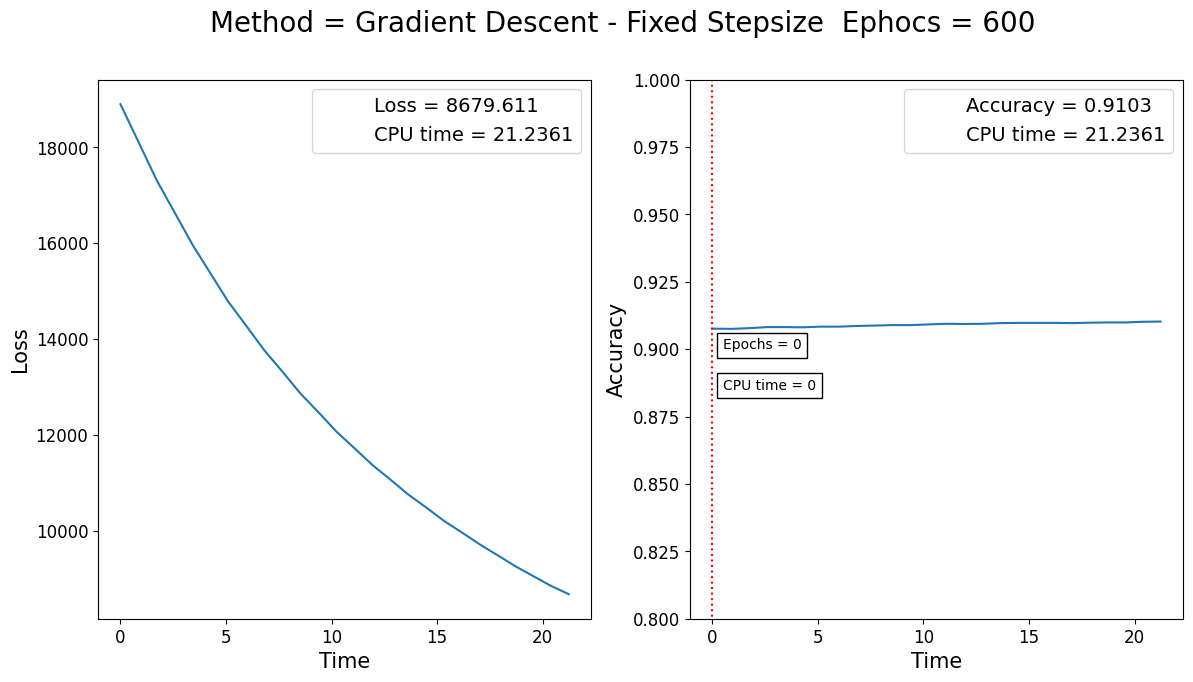

In [134]:
produce_plot(opt_real_fix_gd, 'Gradient Descent - Fixed Stepsize',0, epochs = 600)

### Fixed - Random

In [136]:
print("Optimization Fixed and Random")
opt_real_fix_ran = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', rate = 0.0001, method = "random", epochs = 80000, verbose = True, start = "zero", tol = -1)
print("*************************************************")

Optimization Fixed and Random
Epoch: 0, loss: 18934.8976, accuracy: 0.498973
Epoch: 282, loss: 18933.9819, accuracy: 0.508177
Epoch: 564, loss: 18933.2699, accuracy: 0.518366
Epoch: 846, loss: 18932.479, accuracy: 0.528063
Epoch: 1128, loss: 18931.5943, accuracy: 0.536281
Epoch: 1410, loss: 18930.8744, accuracy: 0.544991
Epoch: 1692, loss: 18929.8516, accuracy: 0.552305
Epoch: 1974, loss: 18928.625, accuracy: 0.560112
Epoch: 2256, loss: 18927.6209, accuracy: 0.568822
Epoch: 2538, loss: 18926.8552, accuracy: 0.575725
Epoch: 2820, loss: 18925.9196, accuracy: 0.582464
Epoch: 3102, loss: 18925.0268, accuracy: 0.589531
Epoch: 3384, loss: 18923.9874, accuracy: 0.596844
Epoch: 3666, loss: 18922.9596, accuracy: 0.601775
Epoch: 3948, loss: 18922.0839, accuracy: 0.609417
Epoch: 4230, loss: 18921.2066, accuracy: 0.616402
Epoch: 4512, loss: 18920.5802, accuracy: 0.623305
Epoch: 4794, loss: 18919.7802, accuracy: 0.630044
Epoch: 5076, loss: 18918.8644, accuracy: 0.637357
Epoch: 5358, loss: 18917.920

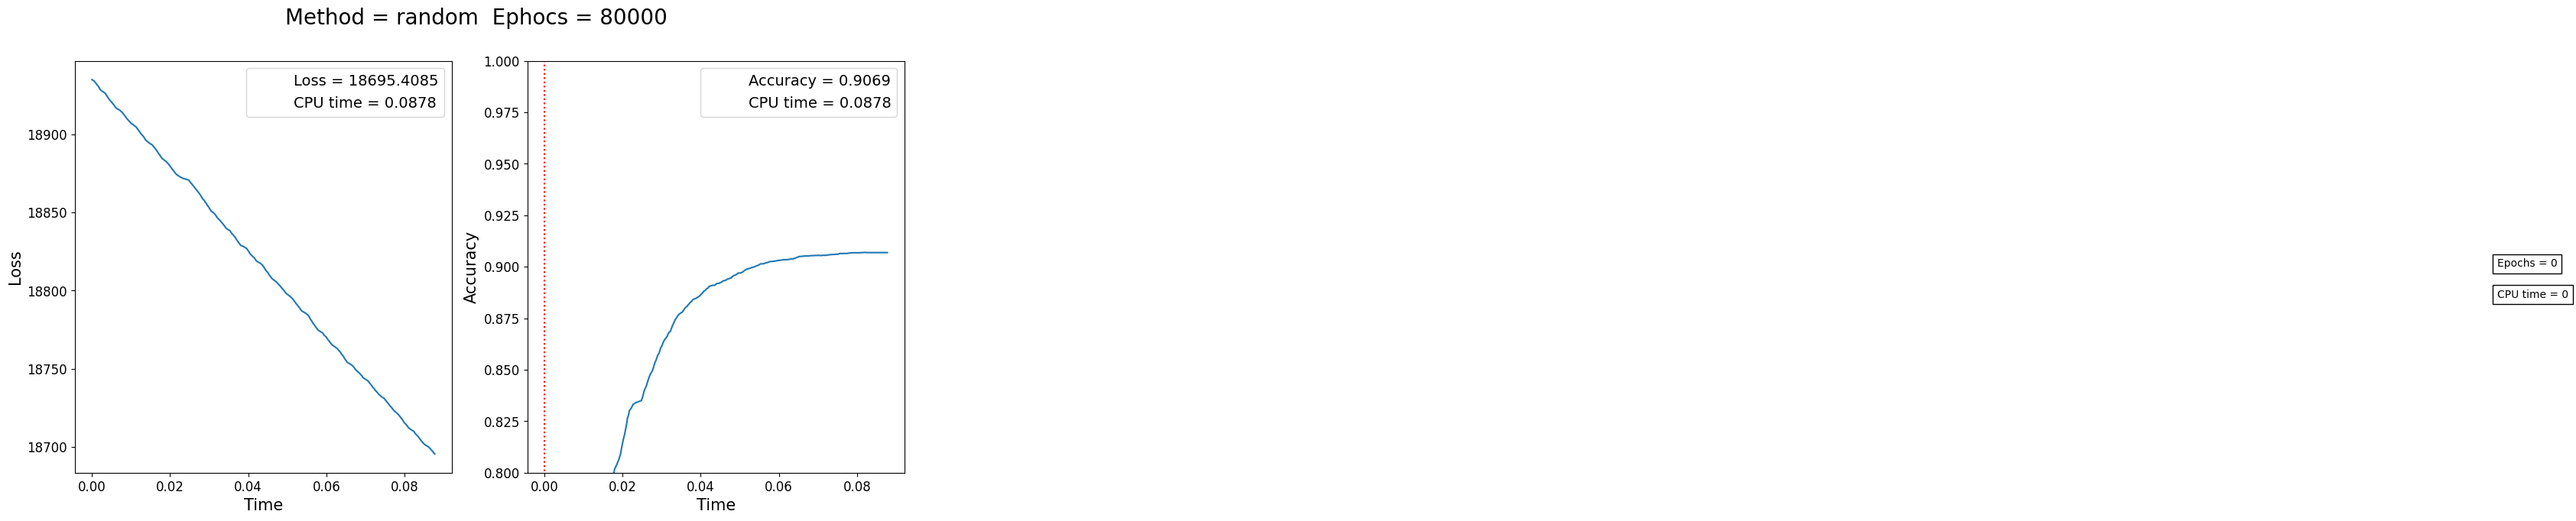

In [137]:
produce_plot(opt_real_fix_ran, 'random',0, epochs = 80000)

### Fixed - Cyclic

In [138]:
print("Optimization Fixed and Cyclic")
opt_real_fix_cyc = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', rate = 0.0001, method = 'cyclic', epochs = 60, verbose = True, start = "zero")
print("*************************************************")

Optimization Fixed and Cyclic
Epoch: 0, loss: 18897.6214, accuracy: 0.90747
Epoch: 1, loss: 18860.5479, accuracy: 0.907552
Epoch: 2, loss: 18823.6714, accuracy: 0.907552
Epoch: 3, loss: 18786.9862, accuracy: 0.907552
Epoch: 4, loss: 18750.4874, accuracy: 0.907552
Epoch: 5, loss: 18714.1698, accuracy: 0.907552
Epoch: 6, loss: 18678.0292, accuracy: 0.907552
Epoch: 7, loss: 18642.061, accuracy: 0.90747
Epoch: 8, loss: 18606.2614, accuracy: 0.90747
Epoch: 9, loss: 18570.6266, accuracy: 0.90747
Epoch: 10, loss: 18535.1529, accuracy: 0.90747
Epoch: 11, loss: 18499.8371, accuracy: 0.90747
Epoch: 12, loss: 18464.6759, accuracy: 0.907388
Epoch: 13, loss: 18429.6664, accuracy: 0.90747
Epoch: 14, loss: 18394.8057, accuracy: 0.907552
Epoch: 15, loss: 18360.0912, accuracy: 0.907552
Epoch: 16, loss: 18325.5203, accuracy: 0.907552
Epoch: 17, loss: 18291.0907, accuracy: 0.907552
Epoch: 18, loss: 18256.8001, accuracy: 0.90747
Epoch: 19, loss: 18222.6463, accuracy: 0.907552
Epoch: 20, loss: 18188.6273, 

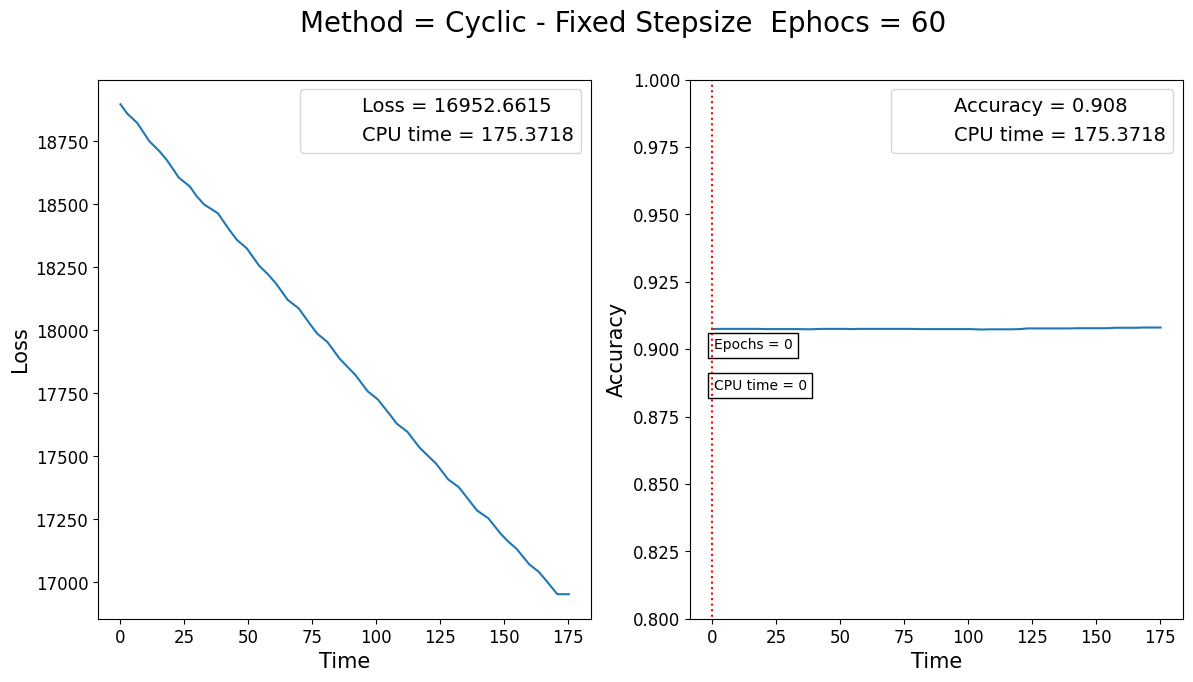

In [139]:
produce_plot(opt_real_fix_cyc, 'Cyclic - Fixed Stepsize',0, epochs = 60)

### Armijo - Gradient Descent

In [141]:
#ARMIJO
print("Optimization Armijo and Gradient Descent")
opt_real_arm_gd = optimization(w_lab, w_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'armijo', method = "gd", epochs = 10,rate = 0.0001, verbose = True, start = "zero")
print("*************************************************")

Optimization Armijo and Gradient Descent
Epoch: 0, loss: 12403.1321, accuracy: 0.907634
Epoch: 1, loss: 10664.5222, accuracy: 0.908209
Epoch: 2, loss: 10229.2974, accuracy: 0.908045
Epoch: 3, loss: 9575.1337, accuracy: 0.909689
Epoch: 4, loss: 7940.3944, accuracy: 0.910099
Epoch: 5, loss: 7465.3861, accuracy: 0.910346
Epoch: 6, loss: 7239.6214, accuracy: 0.910264
Epoch: 7, loss: 7080.4573, accuracy: 0.91051
Epoch: 8, loss: 6943.7141, accuracy: 0.91051
Epoch: 9, loss: 6333.7416, accuracy: 0.911168
Epoch: 10, loss: 6333.741572, accuracy: 0.911168
*************************************************


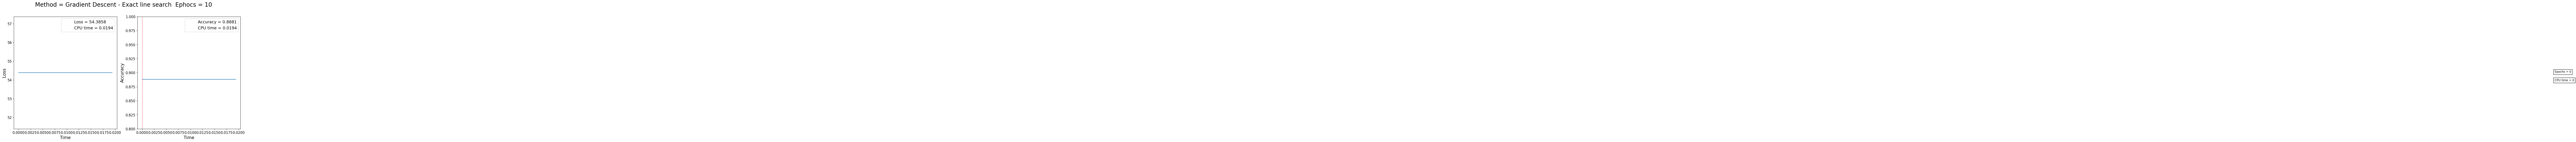

In [142]:
produce_plot(opt_real_exa_gd, 'Gradient Descent - Exact line search',0, epochs = 10)

### Exact - Gradient Descent

In [144]:
#EXACT 
print("Optimization Exact and Gradient Descent")
opt_real_exa_gd = optimization(w_lab, w_unlab,array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'exact', method = "gd", epochs = 5, verbose = True, start = "zero")
print("*************************************************")

Optimization Exact and Gradient Descent
Epoch: 0, loss: 12169.3535, accuracy: 0.907634
Epoch: 1, loss: 9693.7879, accuracy: 0.908292
Epoch: 2, loss: 9197.8678, accuracy: 0.908374
Epoch: 3, loss: 8858.5768, accuracy: 0.90862
Epoch: 4, loss: 8566.2359, accuracy: 0.909195
Epoch: 5, loss: 8566.235853, accuracy: 0.909195
*************************************************


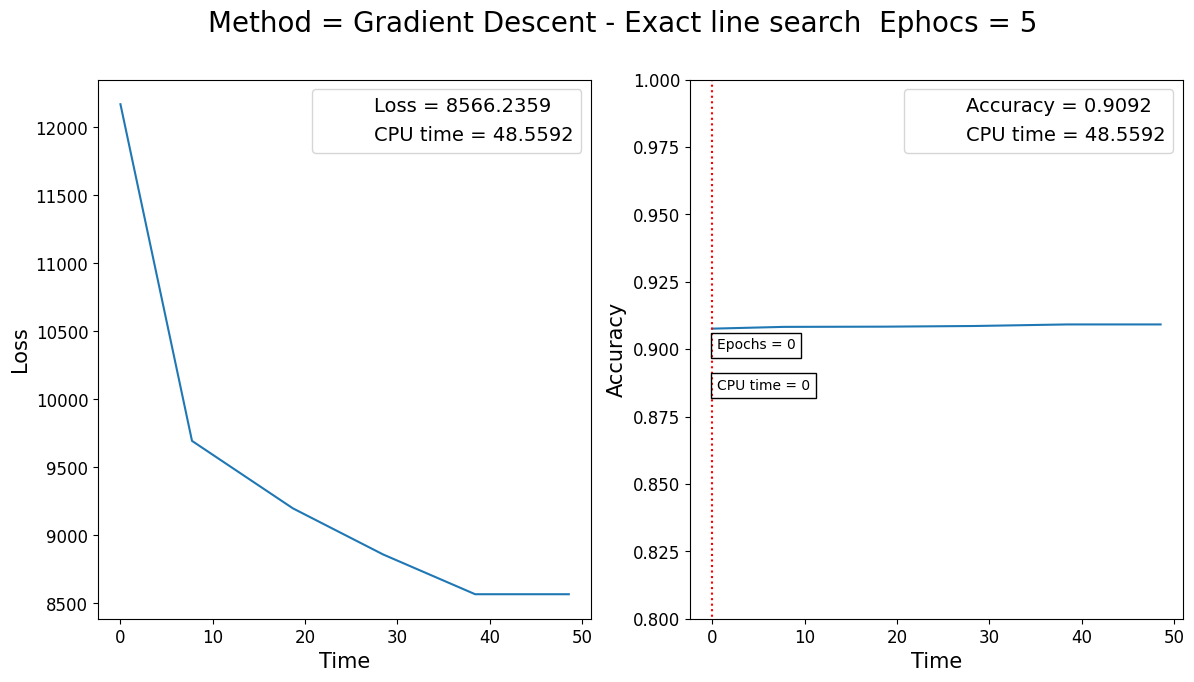

In [145]:
produce_plot(opt_real_exa_gd, 'Gradient Descent - Exact line search',0, epochs = 5)

### Gauss Soutwell

In [146]:
print("Optimization Gauss Southwell BCGD")
opt_real_exa_gs = optimization(w_lab, w_unlab,array_unlab.shape[0], y_lab_array,y_unlab_array,lnsrc='exact', method = "GS", epochs = 5, start = "zero")
print("*************************************************")

Optimization Gauss Southwell BCGD


KeyboardInterrupt: ignored

In [ ]:
produce_plot(opt_real_exa_gs, 'Gauss Southwell - Lipschitz',0, epochs = 5)

sorry no time to run it :(

### Other plots

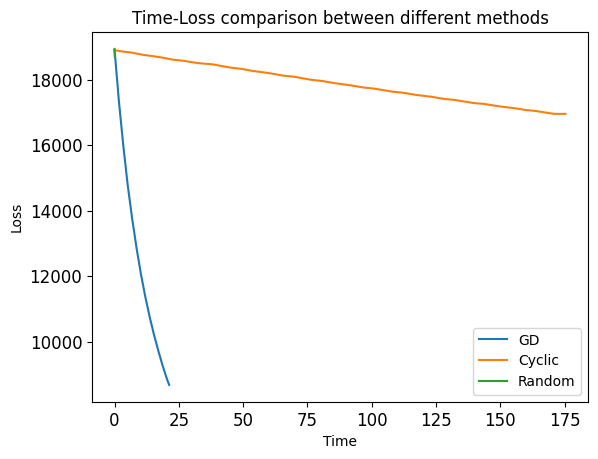

In [147]:
produce_all_plot_loss(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran)

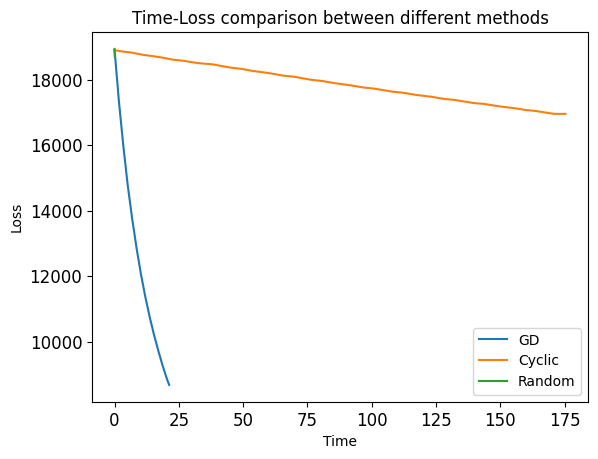

In [148]:
produce_all_plot_loss(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran)